# Create Stock Price with Sentiment Dataset

This notebook downloads stock data from yfinance for all tickers in the sentiment dataset and combines them to create a comprehensive stock_price_with_sentiment.csv file.

In [2]:
import pandas as pd
import yfinance as yf
import numpy as np
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

print("Libraries imported successfully")

Libraries imported successfully


## Load and Examine Sentiment Data

In [3]:
# Load pre-computed sentiment predictions
print("Loading pre-computed sentiment predictions...")
print(" Loading from: historical_news_with_sentiment_llama3allagree.csv")
print("  Make sure you've run predict_news_sentiment_llama3allagreement.ipynb first!")

try:
    df_with_sentiment = pd.read_csv('historical_news_with_sentiment_llama3allagree.csv')
    print(f" Successfully loaded {len(df_with_sentiment):,} news articles with sentiment predictions")
    print(f" Date range: {df_with_sentiment['date'].min()} to {df_with_sentiment['date'].max()}")
    print(f" Tickers: {sorted(df_with_sentiment['ticker'].unique())}")
    print(f" Columns: {list(df_with_sentiment.columns)}")
    
    # Display sample data - using correct column names
    print("\n Sample of sentiment predictions:")
    print(df_with_sentiment[['ticker', 'date', 'title', 'sentiment', 'sentiment_score']].head(3).to_string(index=False))
    
except FileNotFoundError:
    print(" Error: historical_news_with_sentiment_llama3allagree.csv not found!")
    print(" Please run predict_news_sentiment_llama3allagreement.ipynb first to generate sentiment predictions.")
    raise

Loading pre-computed sentiment predictions...
 Loading from: historical_news_with_sentiment_llama3allagree.csv
  Make sure you've run predict_news_sentiment_llama3allagreement.ipynb first!
 Successfully loaded 35,559 news articles with sentiment predictions
 Date range: 2020-06-25 to 2025-06-20
 Tickers: ['AAPL', 'AMZN', 'AVGO', 'BRK.B', 'COST', 'GOOG', 'JNJ', 'JPM', 'LLY', 'MA', 'META', 'MSFT', 'NFLX', 'NVDA', 'ORCL', 'PG', 'TSLA', 'V', 'WMT', 'XOM']
 Columns: ['ticker', 'date', 'title', 'description', 'author', 'published_utc', 'article_url', 'publisher_name', 'publisher_homepage_url', 'tickers', 'keywords', 'description_clean', 'title_clean', 'is_meaningful', 'ticker_count', 'sentiment', 'sentiment_score']

 Sample of sentiment predictions:
ticker       date                                                                  title sentiment  sentiment_score
  AAPL 2022-01-01 Apple Vs. Facebook: How The Race For The Metaverse Space Is Shaping Up   neutral                0
  AAPL 2022-01

## Create Daily Sentiment Aggregations

In [4]:
# Create daily sentiment aggregations from individual article predictions
print("Creating daily sentiment aggregations...")

# Ensure date column is datetime
df_with_sentiment['date'] = pd.to_datetime(df_with_sentiment['date'])

# Map sentiment labels to numeric scores for aggregation
sentiment_mapping = {
    'positive': 1.0,
    'neutral': 0.0, 
    'negative': -1.0
}

# Use the existing sentiment_score column instead of creating new one
# df_with_sentiment['sentiment_score'] = df_with_sentiment['sentiment'].map(sentiment_mapping)

# Create daily aggregations by ticker and date
print(" Aggregating sentiment scores by ticker and date...")

daily_sentiment = df_with_sentiment.groupby(['ticker', 'date']).agg({
    'sentiment_score': ['mean', 'std', 'count'],
    'sentiment': lambda x: x.value_counts().to_dict(),
    'title': 'count'  # Count news volume
}).reset_index()

# Flatten column names
daily_sentiment.columns = [
    'ticker', 'date', 'avg_sentiment_score', 'sentiment_std', 'news_count',
    'sentiment_distribution', 'news_volume'
]

# Handle missing standard deviations (when only 1 article per day)
daily_sentiment['sentiment_std'] = daily_sentiment['sentiment_std'].fillna(0.0)

# Calculate sentiment volatility (same as sentiment_std for compatibility)
daily_sentiment['sentiment_volatility'] = daily_sentiment['sentiment_std']

# Create daily sentiment category (most common sentiment of the day)
def get_dominant_sentiment(dist_dict):
    if isinstance(dist_dict, dict) and dist_dict:
        return max(dist_dict.keys(), key=lambda k: dist_dict[k])
    return 'neutral'

daily_sentiment['daily_sentiment_category'] = daily_sentiment['sentiment_distribution'].apply(get_dominant_sentiment)

# Reorder columns to match expected format
sentiment_df = daily_sentiment[['ticker', 'date', 'avg_sentiment_score', 'sentiment_std', 
                               'news_count', 'sentiment_distribution', 'sentiment_volatility',
                               'news_volume', 'daily_sentiment_category']].copy()

print(f" Created daily sentiment aggregations")
print(f" Shape: {sentiment_df.shape}")
print(f" Date range: {sentiment_df['date'].min()} to {sentiment_df['date'].max()}")
print(f" Unique tickers: {sentiment_df['ticker'].nunique()}")
print(f" Total daily records: {len(sentiment_df):,}")

# Display sample of aggregated data
print("\n Sample daily sentiment aggregations:")
sample_sentiment = sentiment_df.head(5)
print(sample_sentiment[['ticker', 'date', 'avg_sentiment_score', 'news_count', 'daily_sentiment_category']].to_string(index=False))

# Save daily sentiment aggregations
daily_sentiment_file = 'daily_sentiment_scores_llama3allagree.csv'
sentiment_df.to_csv(daily_sentiment_file, index=False)
print(f"\n Saved daily sentiment aggregations to: {daily_sentiment_file}")

Creating daily sentiment aggregations...
 Aggregating sentiment scores by ticker and date...
 Created daily sentiment aggregations
 Shape: (15121, 9)
 Date range: 2020-06-25 00:00:00 to 2025-06-20 00:00:00
 Unique tickers: 20
 Total daily records: 15,121

 Sample daily sentiment aggregations:
ticker       date  avg_sentiment_score  news_count daily_sentiment_category
  AAPL 2020-06-25            -1.000000           1                 negative
  AAPL 2020-09-08            -1.000000           1                 negative
  AAPL 2021-04-24             1.000000           1                 positive
  AAPL 2021-04-25             0.000000           3                  neutral
  AAPL 2021-04-26             0.428571           7                 positive

 Saved daily sentiment aggregations to: daily_sentiment_scores_llama3allagree.csv


In [5]:
# Get unique tickers and date range from aggregated sentiment data
unique_tickers = sentiment_df['ticker'].unique()

# Fix ticker mapping for yfinance compatibility
ticker_mapping = {
    'BRK.B': 'BRK-B'  # yfinance uses BRK-B instead of BRK.B
}

# Apply ticker mapping to sentiment data
sentiment_df['yf_ticker'] = sentiment_df['ticker'].map(ticker_mapping).fillna(sentiment_df['ticker'])
unique_yf_tickers = sentiment_df['yf_ticker'].unique()

print(f"Original tickers ({len(unique_tickers)}): {list(unique_tickers)}")
print(f"YFinance tickers ({len(unique_yf_tickers)}): {list(unique_yf_tickers)}")

# Get date range from sentiment data
date_range = sentiment_df['date'].agg(['min', 'max'])
print(f"\nDate range: {date_range['min'].strftime('%Y-%m-%d')} to {date_range['max'].strftime('%Y-%m-%d')}")
print(f"Total days in sentiment data: {len(sentiment_df)}")

Original tickers (20): ['AAPL', 'AMZN', 'AVGO', 'BRK.B', 'COST', 'GOOG', 'JNJ', 'JPM', 'LLY', 'MA', 'META', 'MSFT', 'NFLX', 'NVDA', 'ORCL', 'PG', 'TSLA', 'V', 'WMT', 'XOM']
YFinance tickers (20): ['AAPL', 'AMZN', 'AVGO', 'BRK-B', 'COST', 'GOOG', 'JNJ', 'JPM', 'LLY', 'MA', 'META', 'MSFT', 'NFLX', 'NVDA', 'ORCL', 'PG', 'TSLA', 'V', 'WMT', 'XOM']

Date range: 2020-06-25 to 2025-06-20
Total days in sentiment data: 15121


Creating monthly news coverage chart...


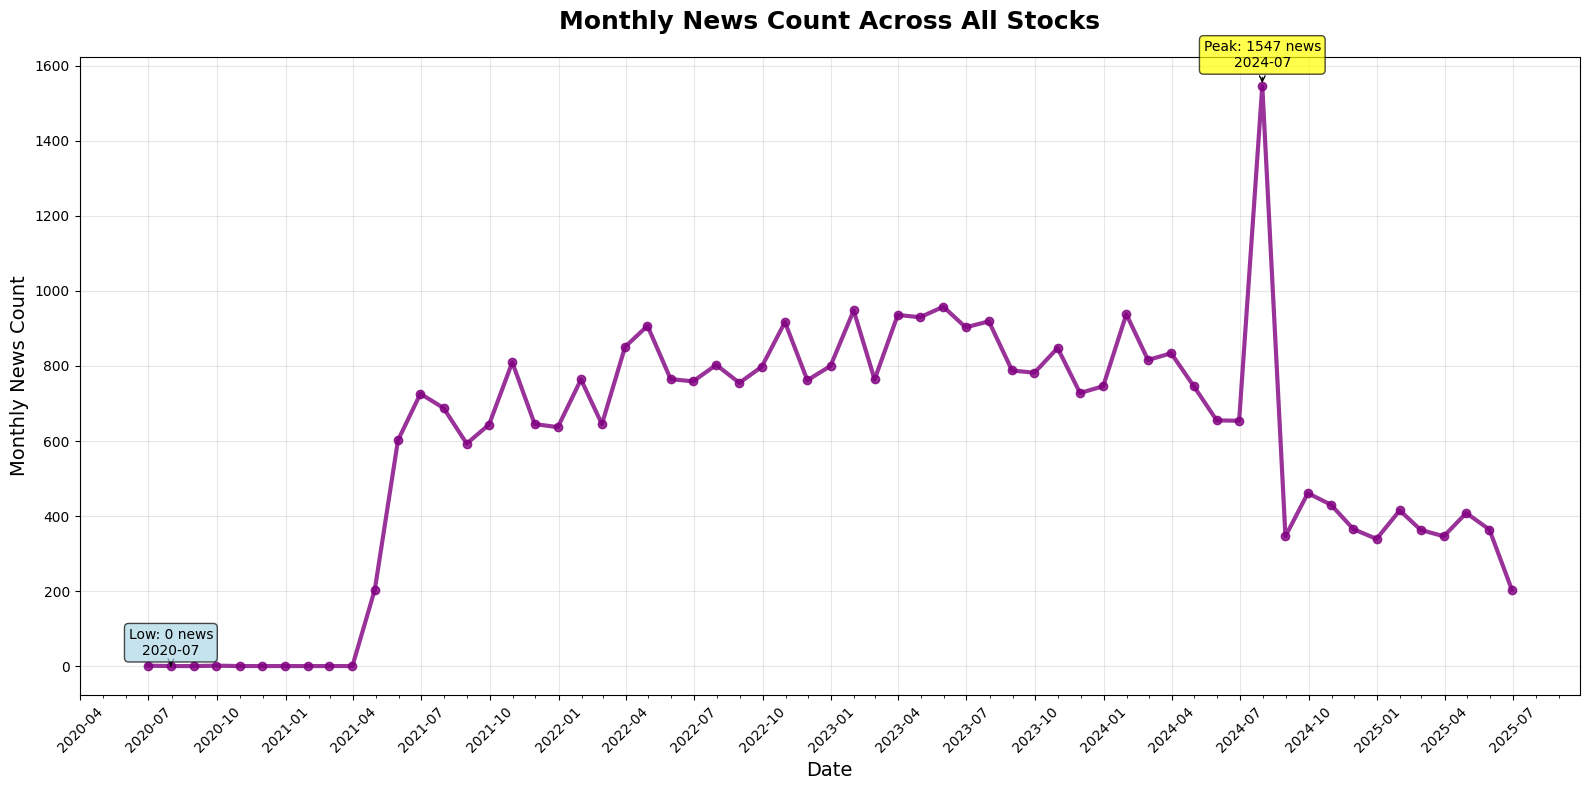


MONTHLY NEWS COVERAGE ANALYSIS:
--------------------------------------------------
Total months analyzed: 61
Average monthly news count: 582.9
Peak month: 2024-07 (1547 news)
Lowest month: 2020-07 (0 news)
Standard deviation: 340.6

Low coverage months (≤363 news, bottom 25%):
  2020-06: 1 news
  2020-07: 0 news
  2020-08: 0 news
  2020-09: 1 news
  2020-10: 0 news
  2020-11: 0 news
  2020-12: 0 news
  2021-01: 0 news
  2021-02: 0 news
  2021-03: 0 news

High coverage months (≥803 news, top 25%):
  2021-10: 810 news
  2022-03: 851 news
  2022-04: 907 news
  2022-07: 803 news
  2022-10: 917 news
  2023-01: 948 news
  2023-03: 936 news
  2023-04: 930 news
  2023-05: 958 news
  2023-06: 903 news

YEARLY MONTHLY AVERAGES:
--------------------------------------------------
  2020: 0.3 avg news/month (7 months)
  2021: 462.4 avg news/month (12 months)
  2022: 793.8 avg news/month (12 months)
  2023: 854.2 avg news/month (12 months)
  2024: 677.7 avg news/month (12 months)
  2025: 350.0 avg 

In [6]:
# =====================================================
# MONTHLY NEWS COVERAGE ANALYSIS
# =====================================================

# print("="*70)
# print("ANALYZING MONTHLY NEWS COVERAGE OVER TIME")
# print("="*70)

# Ensure date column is datetime
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])

# Monthly News Count Analysis
print("Creating monthly news coverage chart...")
plt.figure(figsize=(16, 8))

# Aggregate monthly news count across all stocks
monthly_news = sentiment_df.set_index('date').groupby(pd.Grouper(freq='M'))['news_count'].sum()

# Create the plot
plt.plot(monthly_news.index, monthly_news.values, linewidth=3, color='purple', 
         marker='o', markersize=6, alpha=0.8)

plt.title('Monthly News Count Across All Stocks', fontsize=18, fontweight='bold', pad=20)
plt.ylabel('Monthly News Count', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.grid(True, alpha=0.3)

# Format x-axis to show months clearly
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Every 3 months
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add value annotations for key points
max_idx = monthly_news.idxmax()
max_val = monthly_news.max()
min_idx = monthly_news.idxmin()
min_val = monthly_news.min()

plt.annotate(f'Peak: {max_val} news\n{max_idx.strftime("%Y-%m")}', 
            xy=(max_idx, max_val), xytext=(max_idx, max_val + 50),
            ha='center', fontsize=10, 
            bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7),
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

plt.annotate(f'Low: {min_val} news\n{min_idx.strftime("%Y-%m")}', 
            xy=(min_idx, min_val), xytext=(min_idx, min_val + 30),
            ha='center', fontsize=10,
            bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7),
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

plt.tight_layout()
plt.savefig('monthly_news_coverage.png', dpi=300, bbox_inches='tight')
plt.show()

# Monthly Analysis Statistics
print("\nMONTHLY NEWS COVERAGE ANALYSIS:")
print("-" * 50)

print(f"Total months analyzed: {len(monthly_news)}")
print(f"Average monthly news count: {monthly_news.mean():.1f}")
print(f"Peak month: {max_idx.strftime('%Y-%m')} ({max_val} news)")
print(f"Lowest month: {min_idx.strftime('%Y-%m')} ({min_val} news)")
print(f"Standard deviation: {monthly_news.std():.1f}")

#Identify months with low/high coverage
low_threshold = monthly_news.quantile(0.25)
high_threshold = monthly_news.quantile(0.75)

low_months = monthly_news[monthly_news <= low_threshold]
high_months = monthly_news[monthly_news >= high_threshold]

print(f"\nLow coverage months (≤{low_threshold:.0f} news, bottom 25%):")
for date, count in low_months.head(10).items():
    print(f"  {date.strftime('%Y-%m')}: {count} news")

print(f"\nHigh coverage months (≥{high_threshold:.0f} news, top 25%):")
for date, count in high_months.head(10).items():
    print(f"  {date.strftime('%Y-%m')}: {count} news")

#Year-by-Year Monthly Averages
print(f"\nYEARLY MONTHLY AVERAGES:")
print("-" * 50)
yearly_monthly_avg = monthly_news.groupby(monthly_news.index.year).mean()
for year, avg in yearly_monthly_avg.items():
    year_data = monthly_news[monthly_news.index.year == year]
    print(f"  {year}: {avg:.1f} avg news/month ({len(year_data)} months)")

# # Recommended training periods based on monthly data
# print(f"\nRECOMMENDED TRAINING PERIODS (Based on Monthly Analysis):")
# print("-" * 50)

# # Find consecutive high-coverage months (≥ median)
# median_threshold = monthly_news.median()
# good_months = monthly_news >= median_threshold

# # Group consecutive good months
# good_months_series = good_months.astype(int)
# groups = (good_months_series != good_months_series.shift()).cumsum()
# good_periods = good_months[good_months].groupby(groups[good_months]).agg(['min', 'max', 'count'])

# # Filter for periods with at least 6 consecutive months
# long_periods = good_periods[good_periods['count'] >= 6]

# if len(long_periods) > 0:
#     print("Periods with 6+ consecutive months of good news coverage:")
#     for idx, (start_date, end_date, month_count) in long_periods.iterrows():
#         # Fix the slice indexing error by using proper datetime indexing
#         period_data = monthly_news.loc[start_date:end_date]
#         avg_news = period_data.mean()
#         print(f"  {start_date.strftime('%Y-%m')} to {end_date.strftime('%Y-%m')} "
#               f"({int(month_count)} months, avg {avg_news:.0f} news/month)")
# else:
#     print("No periods with 6+ consecutive months of high coverage found.")
#     print("Consider shorter periods or lower thresholds for training.")

# print("\n" + "="*70)
# print("MONTHLY NEWS COVERAGE ANALYSIS COMPLETE!")
# print("Check 'monthly_news_coverage.png' for the visualization")
# print("="*70)

## Download Stock Data from yfinance

Based on the diagram above, there are no news collected until April 2021, so I set the time range from June 2021 to June 2025, total of 4 years data.

In [7]:
start_date = "2021-06-20"

In [8]:
def download_stock_data(ticker, start_date, end_date):
    """Download stock data for a single ticker"""
    try:
        # Ensure dates are datetime objects for calculation
        if isinstance(start_date, str):
            start_date = pd.to_datetime(start_date).date()
        if isinstance(end_date, str):
            end_date = pd.to_datetime(end_date).date()
            
        # Download data with some buffer before start date
        buffer_start = start_date - timedelta(days=30)
        stock = yf.Ticker(ticker)
        data = stock.history(start=buffer_start, end=end_date + timedelta(days=1))
        
        if data.empty:
            print(f"No data found for {ticker}")
            return None
        
        # Reset index to get date as column
        data = data.reset_index()
        data['Date'] = data['Date'].dt.date
        data['ticker'] = ticker
        
        # Select and rename columns to match expected format
        data = data[['ticker', 'Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
        
        print(f"Downloaded {len(data)} records for {ticker}")
        return data
        
    except Exception as e:
        print(f"Error downloading data for {ticker}: {str(e)}")
        return None

In [9]:
# Download stock data for all tickers
# start_date = date_range['min'].date()
end_date = date_range['max'].date()

print(f"Downloading stock data from {start_date} to {end_date}...")
print(f"Processing {len(unique_yf_tickers)} tickers...\n")

all_stock_data = []

# Create reverse mapping to maintain original ticker names
reverse_mapping = {v: k for k, v in ticker_mapping.items()}

for i, yf_ticker in enumerate(unique_yf_tickers, 1):
    original_ticker = reverse_mapping.get(yf_ticker, yf_ticker)
    print(f"({i}/{len(unique_yf_tickers)}) Processing {original_ticker} (yf: {yf_ticker})...")
    stock_data = download_stock_data(yf_ticker, start_date, end_date)
    
    if stock_data is not None:
        # Use original ticker name for consistency with sentiment data
        stock_data['ticker'] = original_ticker
        all_stock_data.append(stock_data)
    
    # Add small delay to avoid rate limiting
    import time
    time.sleep(0.1)

print(f"\nSuccessfully downloaded data for {len(all_stock_data)} tickers")

Processing 20 tickers...

(1/20) Processing AAPL (yf: AAPL)...
Downloaded 1025 records for AAPL
(2/20) Processing AMZN (yf: AMZN)...
Downloaded 1025 records for AMZN
(3/20) Processing AVGO (yf: AVGO)...
Downloaded 1025 records for AVGO
(4/20) Processing BRK.B (yf: BRK-B)...
Downloaded 1025 records for BRK-B
(5/20) Processing COST (yf: COST)...
Downloaded 1025 records for COST
(6/20) Processing GOOG (yf: GOOG)...
Downloaded 1025 records for GOOG
(7/20) Processing JNJ (yf: JNJ)...
Downloaded 1025 records for JNJ
(8/20) Processing JPM (yf: JPM)...
Downloaded 1025 records for JPM
(9/20) Processing LLY (yf: LLY)...
Downloaded 1025 records for LLY
(10/20) Processing MA (yf: MA)...
Downloaded 1025 records for MA
(11/20) Processing META (yf: META)...
Downloaded 1025 records for META
(12/20) Processing MSFT (yf: MSFT)...
Downloaded 1025 records for MSFT
(13/20) Processing NFLX (yf: NFLX)...
Downloaded 1025 records for NFLX
(14/20) Processing NVDA (yf: NVDA)...
Downloaded 1025 records for NVDA
(

In [10]:
# Combine all stock data
if all_stock_data:
    combined_stock_df = pd.concat(all_stock_data, ignore_index=True)
    print(f"Combined stock data shape: {combined_stock_df.shape}")
    print(f"Date range in stock data: {combined_stock_df['Date'].min()} to {combined_stock_df['Date'].max()}")
    print(f"Tickers in stock data: {sorted(combined_stock_df['ticker'].unique())}")
    
    
else:
    print("No stock data was successfully downloaded!")

Combined stock data shape: (20500, 7)
Date range in stock data: 2021-05-21 to 2025-06-20
Tickers in stock data: ['AAPL', 'AMZN', 'AVGO', 'BRK.B', 'COST', 'GOOG', 'JNJ', 'JPM', 'LLY', 'MA', 'META', 'MSFT', 'NFLX', 'NVDA', 'ORCL', 'PG', 'TSLA', 'V', 'WMT', 'XOM']


In [11]:
## Add Technical Indicators

def calculate_rsi(prices, period=14):
    """Calculate Relative Strength Index (RSI)"""
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_macd(prices, fast=12, slow=26, signal=9):
    """Calculate MACD (Moving Average Convergence Divergence)"""
    ema_fast = prices.ewm(span=fast).mean()
    ema_slow = prices.ewm(span=slow).mean()
    
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=signal).mean()
    histogram = macd_line - signal_line
    
    return macd_line, signal_line, histogram

print("Adding technical indicators to stock data...")
print(f"Processing {len(combined_stock_df)} records across {combined_stock_df['ticker'].nunique()} tickers...")

# Sort by ticker and date for proper calculation
combined_stock_df = combined_stock_df.sort_values(['ticker', 'Date']).reset_index(drop=True)

# Initialize new columns
combined_stock_df['MA_3'] = np.nan
combined_stock_df['MA_7'] = np.nan
combined_stock_df['MA_10'] = np.nan
combined_stock_df['RSI'] = np.nan
combined_stock_df['MACD'] = np.nan
combined_stock_df['MACD_Signal'] = np.nan
combined_stock_df['MACD_Histogram'] = np.nan

# Calculate technical indicators for each ticker
for ticker in combined_stock_df['ticker'].unique():
    print(f"Processing technical indicators for {ticker}...")
    ticker_mask = combined_stock_df['ticker'] == ticker
    ticker_data = combined_stock_df[ticker_mask].copy()
    ticker_data = ticker_data.sort_values('Date').reset_index(drop=True)
    
    # Moving Averages
    combined_stock_df.loc[ticker_mask, 'MA_3'] = ticker_data['Close'].rolling(window=3, min_periods=1).mean()
    combined_stock_df.loc[ticker_mask, 'MA_7'] = ticker_data['Close'].rolling(window=7, min_periods=1).mean()
    combined_stock_df.loc[ticker_mask, 'MA_10'] = ticker_data['Close'].rolling(window=10, min_periods=1).mean()
    
    # RSI
    combined_stock_df.loc[ticker_mask, 'RSI'] = calculate_rsi(ticker_data['Close'])
    
    # MACD
    macd_line, signal_line, histogram = calculate_macd(ticker_data['Close'])
    combined_stock_df.loc[ticker_mask, 'MACD'] = macd_line
    combined_stock_df.loc[ticker_mask, 'MACD_Signal'] = signal_line
    combined_stock_df.loc[ticker_mask, 'MACD_Histogram'] = histogram

# Fill any remaining NaN values with appropriate defaults
combined_stock_df['RSI'] = combined_stock_df['RSI'].fillna(50.0)  # Neutral RSI
combined_stock_df['MACD'] = combined_stock_df['MACD'].fillna(0.0)
combined_stock_df['MACD_Signal'] = combined_stock_df['MACD_Signal'].fillna(0.0)
combined_stock_df['MACD_Histogram'] = combined_stock_df['MACD_Histogram'].fillna(0.0)

print(f"\n✅ Technical indicators added successfully!")
print(f"📊 Updated dataset shape: {combined_stock_df.shape}")
print(f"📈 New technical indicator columns: MA_3, MA_7, MA_10, RSI, MACD, MACD_Signal, MACD_Histogram")

# Display sample with technical indicators
sample_tech = combined_stock_df[['ticker', 'Date', 'Close', 'MA_3', 'MA_7', 'MA_10', 'RSI', 'MACD']].head(10)
print(f"\n🔍 Sample with technical indicators:")
print(sample_tech.to_string(index=False))


Adding technical indicators to stock data...
Processing 20500 records across 20 tickers...
Processing technical indicators for AAPL...
Processing technical indicators for AMZN...
Processing technical indicators for AVGO...
Processing technical indicators for BRK.B...
Processing technical indicators for COST...
Processing technical indicators for GOOG...
Processing technical indicators for JNJ...
Processing technical indicators for JPM...
Processing technical indicators for LLY...
Processing technical indicators for MA...
Processing technical indicators for META...
Processing technical indicators for MSFT...
Processing technical indicators for NFLX...
Processing technical indicators for NVDA...
Processing technical indicators for ORCL...
Processing technical indicators for PG...
Processing technical indicators for TSLA...
Processing technical indicators for V...
Processing technical indicators for WMT...
Processing technical indicators for XOM...

✅ Technical indicators added successful

In [12]:
# Display sample data
# print("\nSample stock data:")
combined_stock_df.head(10)

,ticker,Date,Open,High,Low,Close,Volume,MA_3,MA_7,MA_10,RSI,MACD,MACD_Signal,MACD_Histogram
0,AAPL,2021-05-21,125.087075,125.263227,122.532879,122.748177,79295400,122.748177,122.748177,122.748177,50.0,0.000000,0.000000,0.000000
1,AAPL,2021-05-24,123.315786,125.204521,123.247283,124.382477,63092900,123.565327,123.565327,123.565327,50.0,0.036667,0.020371,0.016296
2,AAPL,2021-05-25,125.087065,125.576382,123.619136,124.186737,72009500,123.772463,123.772463,123.772463,50.0,0.040651,0.028682,0.011969
3,AAPL,2021-05-26,124.245458,124.666265,123.717003,124.137810,56575900,124.235675,123.863800,123.863800,50.0,0.039700,0.032415,0.007286
4,AAPL,2021-05-27,123.736596,124.910936,122.405674,122.601395,94625600,123.641980,123.611319,123.611319,50.0,-0.022789,0.015993,-0.038782
5,AAPL,2021-05-28,122.885183,123.110268,121.886994,121.945709,71311100,122.894971,123.333717,123.333717,50.0,-0.087963,-0.012185,-0.075778
6,AAPL,2021-06-01,122.405663,122.669887,121.290038,121.622765,67637100,122.056623,123.089296,123.089296,50.0,-0.142875,-0.045259,-0.097616
7,AAPL,2021-06-02,121.622771,122.562245,121.397693,122.386093,59278900,121.984856,123.037569,123.001395,50.0,-0.141094,-0.068290,-0.072804
8,AAPL,2021-06-03,122.014200,122.180563,120.497338,120.898575,76229200,121.635811,122.539869,122.767749,50.0,-0.211515,-0.101376,-0.110139
9,AAPL,2021-06-04,121.417255,123.462573,121.201958,123.198341,75169300,122.161003,122.398670,122.810808,50.0,-0.139933,-0.110015,-0.029918


## Combine Stock Data with Sentiment Scores

In [13]:
# Prepare sentiment data for merging
sentiment_merge = sentiment_df.copy()
sentiment_merge['Date'] = sentiment_merge['date'].dt.date

# Select relevant sentiment columns - using only columns that exist in the daily sentiment aggregation
sentiment_columns = ['ticker', 'Date', 'avg_sentiment_score', 'sentiment_std', 'news_volume', 'daily_sentiment_category']
sentiment_merge = sentiment_merge[sentiment_columns]

print(f"Sentiment data prepared for merging: {sentiment_merge.shape}")
print(f"Sentiment columns: {list(sentiment_merge.columns)}")

Sentiment data prepared for merging: (15121, 6)
Sentiment columns: ['ticker', 'Date', 'avg_sentiment_score', 'sentiment_std', 'news_volume', 'daily_sentiment_category']


In [14]:
# Merge stock data with sentiment data
print("Merging stock data with sentiment data...")

# Perform left join to keep all stock data and add sentiment where available
merged_df = pd.merge(combined_stock_df, sentiment_merge, 
                    on=['ticker', 'Date'], 
                    how='left')

print(f"Merged dataset shape: {merged_df.shape}")
print(f"Records with sentiment data: {merged_df['avg_sentiment_score'].notna().sum()}")
print(f"Records without sentiment data: {merged_df['avg_sentiment_score'].isna().sum()}")

# Display sample of merged data
print("\nSample merged data:")
merged_df.head(10)

Merging stock data with sentiment data...
Merged dataset shape: (20500, 18)
Records with sentiment data: 11579
Records without sentiment data: 8921

Sample merged data:


,ticker,Date,Open,High,Low,Close,Volume,MA_3,MA_7,MA_10,RSI,MACD,MACD_Signal,MACD_Histogram,avg_sentiment_score,sentiment_std,news_volume,daily_sentiment_category
0,AAPL,2021-05-21,125.087075,125.263227,122.532879,122.748177,79295400,122.748177,122.748177,122.748177,50.0,0.000000,0.000000,0.000000,0.333333,0.577350,3.0,neutral
1,AAPL,2021-05-24,123.315786,125.204521,123.247283,124.382477,63092900,123.565327,123.565327,123.565327,50.0,0.036667,0.020371,0.016296,0.250000,0.957427,4.0,positive
2,AAPL,2021-05-25,125.087065,125.576382,123.619136,124.186737,72009500,123.772463,123.772463,123.772463,50.0,0.040651,0.028682,0.011969,NaN,NaN,NaN,NaN
3,AAPL,2021-05-26,124.245458,124.666265,123.717003,124.137810,56575900,124.235675,123.863800,123.863800,50.0,0.039700,0.032415,0.007286,0.333333,1.154701,3.0,positive
4,AAPL,2021-05-27,123.736596,124.910936,122.405674,122.601395,94625600,123.641980,123.611319,123.611319,50.0,-0.022789,0.015993,-0.038782,0.000000,0.000000,1.0,neutral
5,AAPL,2021-05-28,122.885183,123.110268,121.886994,121.945709,71311100,122.894971,123.333717,123.333717,50.0,-0.087963,-0.012185,-0.075778,0.000000,0.000000,1.0,neutral
6,AAPL,2021-06-01,122.405663,122.669887,121.290038,121.622765,67637100,122.056623,123.089296,123.089296,50.0,-0.142875,-0.045259,-0.097616,0.500000,0.707107,2.0,positive
7,AAPL,2021-06-02,121.622771,122.562245,121.397693,122.386093,59278900,121.984856,123.037569,123.001395,50.0,-0.141094,-0.068290,-0.072804,NaN,NaN,NaN,NaN
8,AAPL,2021-06-03,122.014200,122.180563,120.497338,120.898575,76229200,121.635811,122.539869,122.767749,50.0,-0.211515,-0.101376,-0.110139,NaN,NaN,NaN,NaN
9,AAPL,2021-06-04,121.417255,123.462573,121.201958,123.198341,75169300,122.161003,122.398670,122.810808,50.0,-0.139933,-0.110015,-0.029918,0.333333,0.816497,6.0,positive


In [15]:
# Add rolling sentiment features (3, 7, 10 days)
print("Adding rolling sentiment features...")

# Sort by ticker and date to ensure proper rolling calculations
merged_df = merged_df.sort_values(['ticker', 'Date']).reset_index(drop=True)

# Convert Date to datetime for rolling operations
merged_df['Date_dt'] = pd.to_datetime(merged_df['Date'])
merged_df = merged_df.set_index('Date_dt')

# Calculate rolling sentiment averages for each ticker
for ticker in merged_df['ticker'].unique():
    ticker_mask = merged_df['ticker'] == ticker
    ticker_data = merged_df[ticker_mask].copy()
    
    # Calculate rolling averages (forward-fill sentiment scores first to handle missing values)
    sentiment_series = ticker_data['avg_sentiment_score'].fillna(method='ffill').fillna(0)
    
    # 3-day rolling average
    merged_df.loc[ticker_mask, 'sentiment_3d_avg'] = sentiment_series.rolling(window=3, min_periods=1).mean()
    
    # 7-day rolling average  
    merged_df.loc[ticker_mask, 'sentiment_7d_avg'] = sentiment_series.rolling(window=7, min_periods=1).mean()
    
    # 10-day rolling average
    merged_df.loc[ticker_mask, 'sentiment_10d_avg'] = sentiment_series.rolling(window=10, min_periods=1).mean()

# Reset index back to Date column
merged_df = merged_df.reset_index()
merged_df = merged_df.drop('Date_dt', axis=1)

print(f"Added rolling sentiment features. Updated dataset shape: {merged_df.shape}")
print(f"New columns: sentiment_3d_avg, sentiment_7d_avg, sentiment_10d_avg")

# Display sample with new features
sample_with_sentiment = merged_df[merged_df['avg_sentiment_score'] != 0].head(5)
print("\nSample with rolling sentiment features:")
print(sample_with_sentiment[['ticker', 'Date', 'avg_sentiment_score', 'sentiment_3d_avg', 'sentiment_7d_avg', 'sentiment_10d_avg']].to_string(index=False))

Adding rolling sentiment features...
Added rolling sentiment features. Updated dataset shape: (20500, 21)
New columns: sentiment_3d_avg, sentiment_7d_avg, sentiment_10d_avg

Sample with rolling sentiment features:
ticker       Date  avg_sentiment_score  sentiment_3d_avg  sentiment_7d_avg  sentiment_10d_avg
  AAPL 2021-05-21             0.333333          0.333333          0.333333           0.333333
  AAPL 2021-05-24             0.250000          0.291667          0.291667           0.291667
  AAPL 2021-05-25                  NaN          0.277778          0.277778           0.277778
  AAPL 2021-05-26             0.333333          0.277778          0.291667           0.291667
  AAPL 2021-06-01             0.500000          0.166667          0.238095           0.238095


## Create ML-Ready Sentiment Features

In [16]:
# =============================================================================
# CREATE ML-READY SENTIMENT FEATURES - ALL FEATURES CREATED HERE
# =============================================================================

print("Creating ML-ready sentiment features...")

# Define the EXACT final ML columns as CONSTANTS (your specification)
ML_COLUMNS = [
    'ticker', 'Date', 'Open', 'High', 'Low', 'Close', 'Volume','MA_3', 'MA_7', 'MA_10',
    'RSI', 'MACD',
    'daily_sentiment_score',  # (from avg_sentiment_score)
    'sentiment_3d_avg', 'sentiment_7d_avg', 'sentiment_10d_avg',
    'sentiment_lag_1d', 'sentiment_lag_3d',
    'sentiment_std', 'sentiment_volatility_3d', 'sentiment_volatility_7d',
    'news_volume', 'news_volume_3d_avg', 'news_volume_7d_avg',
    'daily_sentiment_category', 'stock_id'
]

print(f" Target ML columns ({len(ML_COLUMNS)}): {ML_COLUMNS}")

# Create a copy of merged_df for ML features
ml_features_df = merged_df.copy()

# Sort by ticker and date for proper feature calculation
ml_features_df = ml_features_df.sort_values(['ticker', 'Date']).reset_index(drop=True)
ml_features_df['Date'] = pd.to_datetime(ml_features_df['Date'])

# Calculate ALL sentiment features for each ticker in this section
print(" Adding ALL ML-ready sentiment features...")

for ticker in ml_features_df['ticker'].unique():
    ticker_mask = ml_features_df['ticker'] == ticker
    ticker_data = ml_features_df[ticker_mask].copy()
    ticker_data = ticker_data.sort_values('Date')
    
    # Primary sentiment lag features (for predictive modeling)
    ml_features_df.loc[ticker_mask, 'sentiment_lag_1d'] = ticker_data['avg_sentiment_score'].shift(1)
    ml_features_df.loc[ticker_mask, 'sentiment_lag_3d'] = ticker_data['sentiment_3d_avg'].shift(1)
    
    # News volume rolling averages
    ml_features_df.loc[ticker_mask, 'news_volume_3d_avg'] = ticker_data['news_volume'].rolling(window=3, min_periods=1).mean()
    ml_features_df.loc[ticker_mask, 'news_volume_7d_avg'] = ticker_data['news_volume'].rolling(window=7, min_periods=1).mean()
    
    # Sentiment volatility features (rolling standard deviation)
    ml_features_df.loc[ticker_mask, 'sentiment_volatility_3d'] = ticker_data['avg_sentiment_score'].rolling(window=3, min_periods=1).std()
    ml_features_df.loc[ticker_mask, 'sentiment_volatility_7d'] = ticker_data['avg_sentiment_score'].rolling(window=7, min_periods=1).std()

# Add stock_id column (numbering each ticker starting from 0)
ticker_to_id = {ticker: idx for idx, ticker in enumerate(sorted(ml_features_df['ticker'].unique()))}
ml_features_df['stock_id'] = ml_features_df['ticker'].map(ticker_to_id)

# Rename avg_sentiment_score to daily_sentiment_score for clarity
ml_features_df['daily_sentiment_score'] = ml_features_df['avg_sentiment_score']

# Fill NaN values created by shift() and rolling operations
sentiment_feature_cols = [
    'sentiment_lag_1d', 'sentiment_lag_3d',
    'news_volume_3d_avg', 'news_volume_7d_avg',
    'sentiment_volatility_3d', 'sentiment_volatility_7d'
]

for col in sentiment_feature_cols:
    if col in ml_features_df.columns:
        ml_features_df[col] = ml_features_df[col].fillna(0.0)

# Check which ML columns exist in our dataframe
print(f"\n Checking ML column availability:")
available_cols = []
missing_cols = []

for col in ML_COLUMNS:
    if col in ml_features_df.columns:
        available_cols.append(col)
        print(f"    {col}")
    else:
        missing_cols.append(col)
        print(f"    {col} - MISSING")

if missing_cols:
    print(f"\n  Missing columns detected: {missing_cols}")
    print("Creating missing columns with default values...")
    
    # Create missing columns with appropriate defaults
    for col in missing_cols:
        if 'sentiment' in col or 'news' in col:
            ml_features_df[col] = 0.0
        elif col == 'daily_sentiment_category':
            ml_features_df[col] = 'neutral'
        elif col == 'stock_id':
            ml_features_df[col] = 0
        else:
            print(f"     Unknown missing column: {col}")

# Create final ML dataset with ONLY the specified columns
final_ml_dataset = ml_features_df[ML_COLUMNS].copy()

print(f"\n Created ML-ready sentiment features")
print(f" Shape: {final_ml_dataset.shape}")
print(f" Features: {len(ML_COLUMNS)} columns")
print(f" Date range: {final_ml_dataset['Date'].min()} to {final_ml_dataset['Date'].max()}")

# Display the exact columns created
print(f"\n FINAL ML COLUMNS ({len(ML_COLUMNS)}):")
for i, col in enumerate(ML_COLUMNS, 1):
    print(f"   {i:2d}. {col}")

# Display feature summary
print(f"\n Sentiment Features Summary:")
sentiment_only_cols = [col for col in ML_COLUMNS if 'sentiment' in col or 'news' in col]
print(f"   Sentiment/News features: {len(sentiment_only_cols)}")
for col in sentiment_only_cols:
    if col in final_ml_dataset.columns:
        non_zero_count = (final_ml_dataset[col] != 0).sum()
        print(f"   - {col}: {non_zero_count:,} non-zero values ({non_zero_count/len(final_ml_dataset)*100:.1f}%)")

print(f"\n FINAL ML DATASET READY!")
print(f"   • {len(final_ml_dataset):,} records across {final_ml_dataset['ticker'].nunique()} stocks")
print(f"   • {len(sentiment_only_cols)} sentiment/news features + {len(ML_COLUMNS) - len(sentiment_only_cols)} price/volume features")
print(f"   • Exact columns as specified in requirements")
print(f"   • Ready for LSTM, XGBoost, or other ML models")

# Store the final dataset and constants for next cells
globals()['final_dataset'] = final_ml_dataset
globals()['ML_COLUMNS'] = ML_COLUMNS

Creating ML-ready sentiment features...
 Target ML columns (26): ['ticker', 'Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'MA_3', 'MA_7', 'MA_10', 'RSI', 'MACD', 'daily_sentiment_score', 'sentiment_3d_avg', 'sentiment_7d_avg', 'sentiment_10d_avg', 'sentiment_lag_1d', 'sentiment_lag_3d', 'sentiment_std', 'sentiment_volatility_3d', 'sentiment_volatility_7d', 'news_volume', 'news_volume_3d_avg', 'news_volume_7d_avg', 'daily_sentiment_category', 'stock_id']
 Adding ALL ML-ready sentiment features...

 Checking ML column availability:
    ticker
    Date
    Open
    High
    Low
    Close
    Volume
    MA_3
    MA_7
    MA_10
    RSI
    MACD
    daily_sentiment_score
    sentiment_3d_avg
    sentiment_7d_avg
    sentiment_10d_avg
    sentiment_lag_1d
    sentiment_lag_3d
    sentiment_std
    sentiment_volatility_3d
    sentiment_volatility_7d
    news_volume
    news_volume_3d_avg
    news_volume_7d_avg
    daily_sentiment_category
    stock_id

 Created ML-ready sentiment features


## Add Stock ID and Final Processing

In [17]:
# Use the final dataset and constants from the ML features section
print("Using final dataset and constants from ML-Ready Sentiment Features section...")

try:
    # Get the final dataset and column constants from the previous cell
    final_df = globals()['final_dataset'].copy()
    ML_COLUMNS = globals()['ML_COLUMNS']
    
    print(f" Successfully retrieved final dataset and constants")
    print(f" Final dataset shape: {final_df.shape}")
    print(f" Final columns ({len(final_df.columns)}): {list(final_df.columns)}")
    
    # Verify we have all the required columns from ML_COLUMNS
    missing_columns = [col for col in ML_COLUMNS if col not in final_df.columns]
    if missing_columns:
        print(f" Missing required columns: {missing_columns}")
    else:
        print(f" All {len(ML_COLUMNS)} required columns present")
    
    # Verify column order matches ML_COLUMNS
    if list(final_df.columns) == ML_COLUMNS:
        print(f" Column order matches ML_COLUMNS specification")
    else:
        print(f"  Reordering columns to match ML_COLUMNS specification")
        final_df = final_df[ML_COLUMNS]
    
    # Display stock_id mapping
    ticker_to_id = {ticker: final_df[final_df['ticker'] == ticker]['stock_id'].iloc[0] 
                    for ticker in sorted(final_df['ticker'].unique())}
    print(f"\n Stock ID mapping: {ticker_to_id}")
    
except KeyError as e:
    print(f" Error retrieving from previous cell: {e}")
    print("Using merged_df as fallback...")
    final_df = merged_df.copy()
    
    # Define ML_COLUMNS as fallback
    ML_COLUMNS = [
        'ticker', 'Date', 'Open', 'High', 'Low', 'Close', 'Volume',
        'daily_sentiment_score', 'sentiment_3d_avg', 'sentiment_7d_avg', 'sentiment_10d_avg',
        'sentiment_lag_1d', 'sentiment_lag_3d',
        'sentiment_std', 'sentiment_volatility_3d', 'sentiment_volatility_7d',
        'news_volume', 'news_volume_3d_avg', 'news_volume_7d_avg',
        'daily_sentiment_category', 'stock_id'
    ]

print(f"\n Final processing completed!")
print(f"   • Using ML_COLUMNS constant to ensure consistency")
print(f"   • All ML features created in the ML-Ready Sentiment Features section")
print(f"   • No duplicate feature creation")
print(f"   • Dataset ready for export with exact columns specified")

Using final dataset and constants from ML-Ready Sentiment Features section...
 Successfully retrieved final dataset and constants
 Final dataset shape: (20500, 26)
 Final columns (26): ['ticker', 'Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'MA_3', 'MA_7', 'MA_10', 'RSI', 'MACD', 'daily_sentiment_score', 'sentiment_3d_avg', 'sentiment_7d_avg', 'sentiment_10d_avg', 'sentiment_lag_1d', 'sentiment_lag_3d', 'sentiment_std', 'sentiment_volatility_3d', 'sentiment_volatility_7d', 'news_volume', 'news_volume_3d_avg', 'news_volume_7d_avg', 'daily_sentiment_category', 'stock_id']
 All 26 required columns present
 Column order matches ML_COLUMNS specification

 Stock ID mapping: {'AAPL': 0, 'AMZN': 1, 'AVGO': 2, 'BRK.B': 3, 'COST': 4, 'GOOG': 5, 'JNJ': 6, 'JPM': 7, 'LLY': 8, 'MA': 9, 'META': 10, 'MSFT': 11, 'NFLX': 12, 'NVDA': 13, 'ORCL': 14, 'PG': 15, 'TSLA': 16, 'V': 17, 'WMT': 18, 'XOM': 19}

 Final processing completed!
   • Using ML_COLUMNS constant to ensure consistency
   • All ML fea

In [18]:
# Handle missing sentiment values using ML_COLUMNS constant
print("Handling missing sentiment values using ML_COLUMNS specification...")
print(f"Current dataset shape: {final_df.shape}")
print(f"Working with ML_COLUMNS: {len(ML_COLUMNS)} columns")

# Check for missing values ONLY in ML_COLUMNS
print("\nMissing data summary (ML_COLUMNS only):")
missing_summary = final_df.isnull().sum()
has_missing = missing_summary[missing_summary > 0]
if len(has_missing) > 0:
    print(has_missing)
else:
    print("No missing values found in any ML columns")

# Define fill values for ML columns only
ml_fill_values = {
    # Technical indicators
    'MA_3': 0.0,
    'MA_7': 0.0,
    'MA_10': 0.0,
    'RSI': 50.0,  # Neutral RSI
    'MACD': 0.0,
    'MACD_Signal': 0.0,
    'MACD_Histogram': 0.0,
    # Sentiment features
    'daily_sentiment_score': 0.0,  # Neutral sentiment
    'sentiment_3d_avg': 0.0,
    'sentiment_7d_avg': 0.0, 
    'sentiment_10d_avg': 0.0,
    'sentiment_lag_1d': 0.0,
    'sentiment_lag_3d': 0.0,
    'sentiment_std': 0.0,
    'sentiment_volatility_3d': 0.0,
    'sentiment_volatility_7d': 0.0,
    'news_volume': 0.0,
    'news_volume_3d_avg': 0.0,
    'news_volume_7d_avg': 0.0,
    'daily_sentiment_category': 'neutral',
    'stock_id': 0
}

# Only fill values for ML columns that exist and have missing data
filled_count = 0
for col in ML_COLUMNS:
    if col in final_df.columns and col in ml_fill_values and final_df[col].isnull().any():
        fill_value = ml_fill_values[col]
        before_count = final_df[col].isnull().sum()
        final_df[col] = final_df[col].fillna(fill_value)
        filled_count += before_count
        print(f" Filled {before_count} missing values in {col} with {fill_value}")

if filled_count == 0:
    print(" No missing values to fill in ML columns")

print("\nAfter filling missing values:")
missing_after = final_df.isnull().sum()
has_missing_after = missing_after[missing_after > 0]
if len(has_missing_after) > 0:
    print("  Still have missing values:")
    print(has_missing_after)
else:
    print(" No missing values remaining in dataset")

# Ensure we only have ML_COLUMNS in the final dataset
if list(final_df.columns) != ML_COLUMNS:
    print(f"\n  Dataset has extra columns. Selecting only ML_COLUMNS...")
    print(f"   Before: {len(final_df.columns)} columns")
    final_df = final_df[ML_COLUMNS]
    print(f"   After: {len(final_df.columns)} columns")

# Sort by ticker and date for final organization
final_df = final_df.sort_values(['ticker', 'Date']).reset_index(drop=True)

# Display final dataset info
print(f"\n Final dataset summary:")
print(f"   Shape: {final_df.shape}")
print(f"   Columns: {len(final_df.columns)} (matches ML_COLUMNS: {len(final_df.columns) == len(ML_COLUMNS)})")
print(f"   Date range: {final_df['Date'].min()} to {final_df['Date'].max()}")
print(f"   Tickers: {final_df['ticker'].nunique()}")

# Display first few rows with key columns
key_display_cols = ['ticker', 'Date', 'Close', 'daily_sentiment_score', 'sentiment_lag_1d', 'stock_id']
available_display_cols = [col for col in key_display_cols if col in final_df.columns]
print(f"\n Sample data ({', '.join(available_display_cols)}):")
print(final_df[available_display_cols].head().to_string(index=False))

Handling missing sentiment values using ML_COLUMNS specification...
Current dataset shape: (20500, 26)
Working with ML_COLUMNS: 26 columns

Missing data summary (ML_COLUMNS only):
MA_3                        19475
MA_7                        19475
MA_10                       19475
daily_sentiment_score        8921
sentiment_std                8921
news_volume                  8921
daily_sentiment_category     8921
dtype: int64
 Filled 19475 missing values in MA_3 with 0.0
 Filled 19475 missing values in MA_7 with 0.0
 Filled 19475 missing values in MA_10 with 0.0
 Filled 8921 missing values in daily_sentiment_score with 0.0
 Filled 8921 missing values in sentiment_std with 0.0
 Filled 8921 missing values in news_volume with 0.0
 Filled 8921 missing values in daily_sentiment_category with neutral

After filling missing values:
 No missing values remaining in dataset

 Final dataset summary:
   Shape: (20500, 26)
   Columns: 26 (matches ML_COLUMNS: True)
   Date range: 2021-05-21 00:00:0

In [19]:
# Final validation of ML dataset
print("Final validation of ML dataset...")

# Verify we have the exact ML_COLUMNS structure
try:
    ML_COLUMNS = globals()['ML_COLUMNS']
    print(f" Using ML_COLUMNS constant: {len(ML_COLUMNS)} columns")
except KeyError:
    # Fallback definition with technical indicators
    ML_COLUMNS = [
        'ticker', 'Date', 'Open', 'High', 'Low', 'Close', 'Volume',
        'MA_3', 'MA_7', 'MA_10',  # Moving averages
        'RSI',  # Relative Strength Index
        'MACD', 'MACD_Signal', 'MACD_Histogram',  # MACD indicators
        'daily_sentiment_score', 'sentiment_3d_avg', 'sentiment_7d_avg', 'sentiment_10d_avg',
        'sentiment_lag_1d', 'sentiment_lag_3d',
        'sentiment_std', 'sentiment_volatility_3d', 'sentiment_volatility_7d',
        'news_volume', 'news_volume_3d_avg', 'news_volume_7d_avg',
        'daily_sentiment_category', 'stock_id'
    ]
    print(f"  Using fallback ML_COLUMNS definition")

# Final dataset validation
print(f"\n Final dataset validation:")
print(f"   Dataset shape: {final_df.shape}")
print(f"   Expected columns: {len(ML_COLUMNS)}")
print(f"   Actual columns: {len(final_df.columns)}")

# Check column alignment
if list(final_df.columns) == ML_COLUMNS:
    print(f"    Column structure matches ML_COLUMNS exactly")
else:
    print(f"     Column structure mismatch")
    print(f"   Expected: {ML_COLUMNS}")
    print(f"   Actual:   {list(final_df.columns)}")
    
    # Fix column structure
    missing_in_df = [col for col in ML_COLUMNS if col not in final_df.columns]
    extra_in_df = [col for col in final_df.columns if col not in ML_COLUMNS]
    
    if missing_in_df:
        print(f"   Missing from dataset: {missing_in_df}")
    if extra_in_df:
        print(f"   Extra in dataset: {extra_in_df}")
    
    # Select only ML_COLUMNS in correct order
    available_ml_cols = [col for col in ML_COLUMNS if col in final_df.columns]
    final_df = final_df[available_ml_cols]
    print(f"   🔧 Restructured to match ML_COLUMNS")

# Final missing data check
missing_data = final_df.isnull().sum()
has_missing = missing_data[missing_data > 0]

if len(has_missing) > 0:
    print(f"\n  Final missing data detected:")
    print(has_missing)
else:
    print(f"\n No missing data in final dataset")

# Data type verification
print(f"\n Data types validation:")
expected_types = {
    'ticker': 'object',
    'Date': 'datetime64[ns]',
    'daily_sentiment_category': 'object'
}

for col in final_df.columns:
    dtype = str(final_df[col].dtype)
    if col in expected_types:
        expected = expected_types[col]
        status = "" if expected in dtype else ""
        print(f"   {status} {col}: {dtype} (expected: {expected})")
    elif col in ['Open', 'High', 'Low', 'Close', 'Volume'] or 'sentiment' in col or 'news' in col:
        status = "" if 'float' in dtype or 'int' in dtype else ""
        print(f"   {status} {col}: {dtype} (expected: numeric)")
    else:
        print(f"   ℹ  {col}: {dtype}")

# Sort by ticker and date for final organization
final_df = final_df.sort_values(['ticker', 'Date']).reset_index(drop=True)

print(f"\n Final dataset ready for export!")
print(f"   Shape: {final_df.shape}")
print(f"   Columns match specification: {list(final_df.columns) == ML_COLUMNS}")
print(f"   Ready for ML model training")

Final validation of ML dataset...
 Using ML_COLUMNS constant: 26 columns

 Final dataset validation:
   Dataset shape: (20500, 26)
   Expected columns: 26
   Actual columns: 26
    Column structure matches ML_COLUMNS exactly

 No missing data in final dataset

 Data types validation:
    ticker: object (expected: object)
    Date: datetime64[ns] (expected: datetime64[ns])
    Open: float64 (expected: numeric)
    High: float64 (expected: numeric)
    Low: float64 (expected: numeric)
    Close: float64 (expected: numeric)
    Volume: int64 (expected: numeric)
   ℹ  MA_3: float64
   ℹ  MA_7: float64
   ℹ  MA_10: float64
   ℹ  RSI: float64
   ℹ  MACD: float64
    daily_sentiment_score: float64 (expected: numeric)
    sentiment_3d_avg: float64 (expected: numeric)
    sentiment_7d_avg: float64 (expected: numeric)
    sentiment_10d_avg: float64 (expected: numeric)
    sentiment_lag_1d: float64 (expected: numeric)
    sentiment_lag_3d: float64 (expected: numeric)
    sentiment_std: float64 (e

## Export to CSV

In [20]:
# Export to CSV using ML_COLUMNS constant
try:
    ML_COLUMNS = globals()['ML_COLUMNS']
    print(f" Using ML_COLUMNS constant for export")
except KeyError:
    # Fallback if ML_COLUMNS not available
    ML_COLUMNS = list(final_df.columns)
    print(f"  Using current dataframe columns")

output_filename = 'stock_price_with_sentiment.csv'
final_df.to_csv(output_filename, index=False)

print(f"Dataset exported to {output_filename}")
print(f"Total records: {len(final_df)}")
print(f"Date range: {final_df['Date'].min()} to {final_df['Date'].max()}")
print(f"Tickers: {len(final_df['ticker'].unique())} ({sorted(final_df['ticker'].unique())})")

# Summary statistics by ticker using correct column names
print("\nRecords per ticker:")
ticker_counts = final_df['ticker'].value_counts().sort_index()

# Use the correct sentiment column name based on what's in ML_COLUMNS
sentiment_col = 'daily_sentiment_score' if 'daily_sentiment_score' in final_df.columns else 'avg_sentiment_score'

for ticker, count in ticker_counts.items():
    if sentiment_col in final_df.columns:
        sentiment_count = final_df[(final_df['ticker'] == ticker) & (final_df[sentiment_col] != 0)].shape[0]
        print(f"{ticker}: {count} records ({sentiment_count} with sentiment data)")
    else:
        print(f"{ticker}: {count} records")

print(f"\n Export completed with {len(ML_COLUMNS)} columns as specified")
print(f" Exported columns: {list(final_df.columns)}")

 Using ML_COLUMNS constant for export
Dataset exported to stock_price_with_sentiment.csv
Total records: 20500
Date range: 2021-05-21 00:00:00 to 2025-06-20 00:00:00
Tickers: 20 (['AAPL', 'AMZN', 'AVGO', 'BRK.B', 'COST', 'GOOG', 'JNJ', 'JPM', 'LLY', 'MA', 'META', 'MSFT', 'NFLX', 'NVDA', 'ORCL', 'PG', 'TSLA', 'V', 'WMT', 'XOM'])

Records per ticker:
AAPL: 1025 records (737 with sentiment data)
AMZN: 1025 records (798 with sentiment data)
AVGO: 1025 records (256 with sentiment data)
BRK.B: 1025 records (491 with sentiment data)
COST: 1025 records (330 with sentiment data)
GOOG: 1025 records (496 with sentiment data)
JNJ: 1025 records (354 with sentiment data)
JPM: 1025 records (361 with sentiment data)
LLY: 1025 records (293 with sentiment data)
MA: 1025 records (235 with sentiment data)
META: 1025 records (412 with sentiment data)
MSFT: 1025 records (646 with sentiment data)
NFLX: 1025 records (223 with sentiment data)
NVDA: 1025 records (725 with sentiment data)
ORCL: 1025 records (191 

## Data Quality Check

CREATING SPECIFIC VISUALIZATIONS
 Using ML_COLUMNS for visualization: 26 columns
 Stock Categories Defined:
   Technology: ['AAPL', 'MSFT', 'GOOG', 'META', 'NVDA', 'ORCL', 'TSLA']
   E-commerce/Cloud: ['AMZN']
   Streaming/Entertainment: ['NFLX']
   Finance: ['JPM', 'V', 'MA', 'BRK.B']
   Healthcare/Pharma: ['JNJ', 'LLY']
   Consumer/Retail: ['WMT', 'COST', 'PG']
   Semiconductor: ['AVGO']
   Energy: ['XOM']

Available Mag 7 stocks: ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'NVDA', 'TSLA', 'META']

1. Creating Mag 7 stocks price chart...


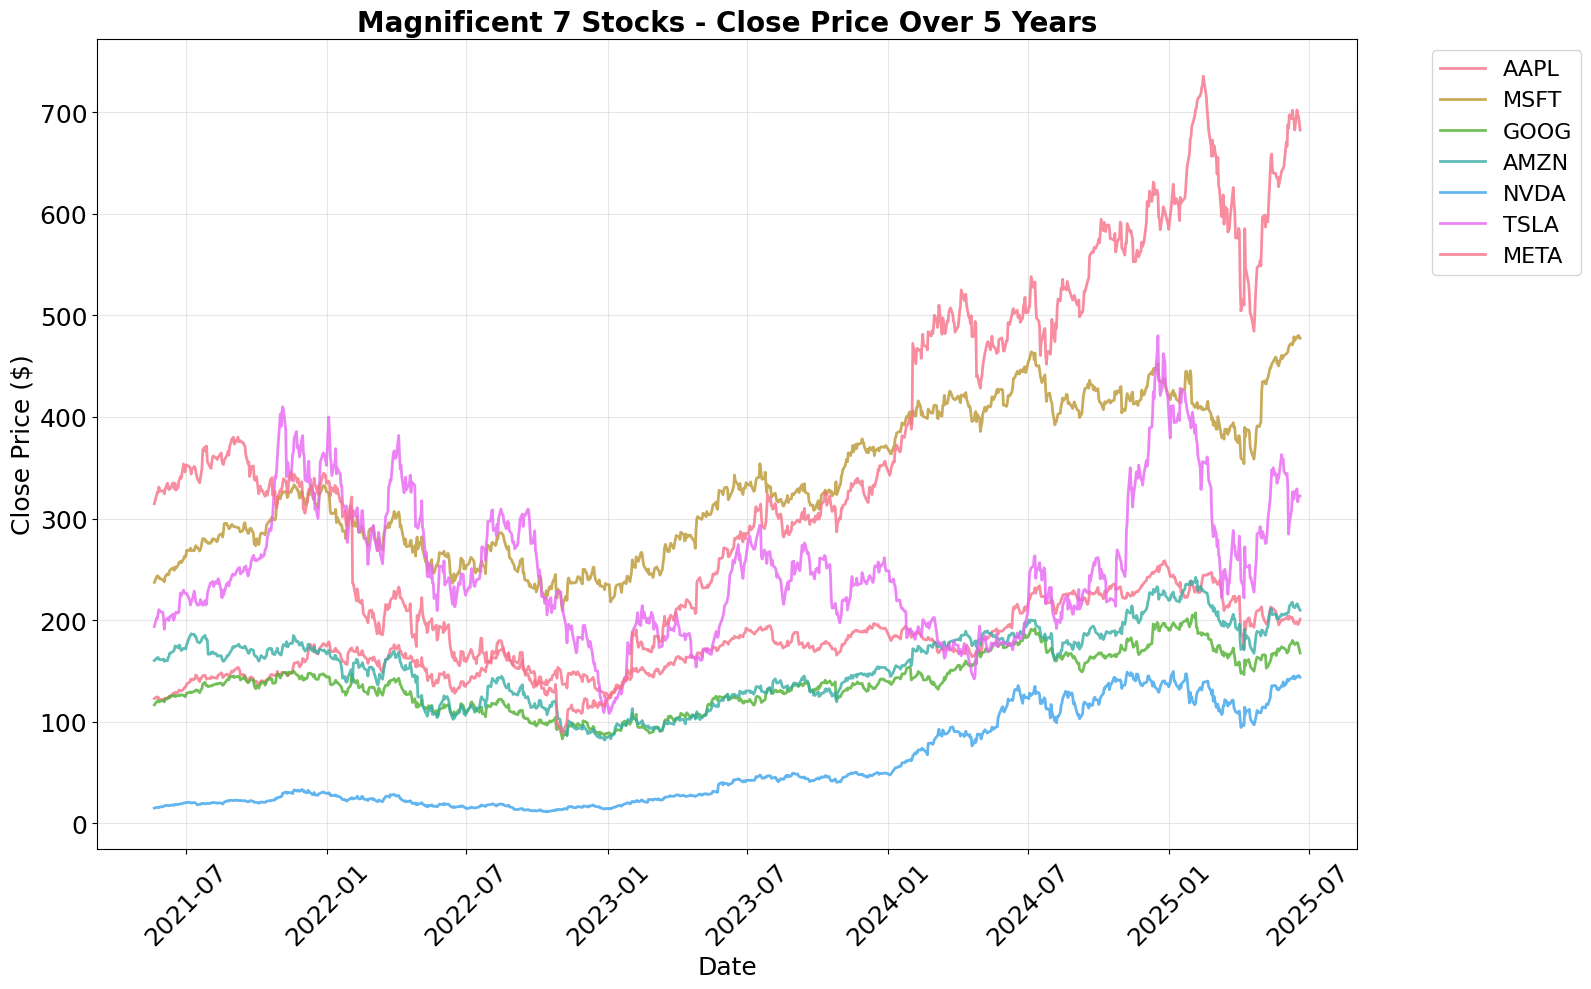


2. Creating correlation matrix...
Using numeric columns for correlation: ['Open', 'High', 'Low', 'Close', 'Volume', 'daily_sentiment_score', 'sentiment_3d_avg', 'sentiment_7d_avg', 'sentiment_10d_avg', 'sentiment_std', 'sentiment_volatility_3d', 'sentiment_volatility_7d', 'news_volume', 'news_volume_3d_avg', 'news_volume_7d_avg']


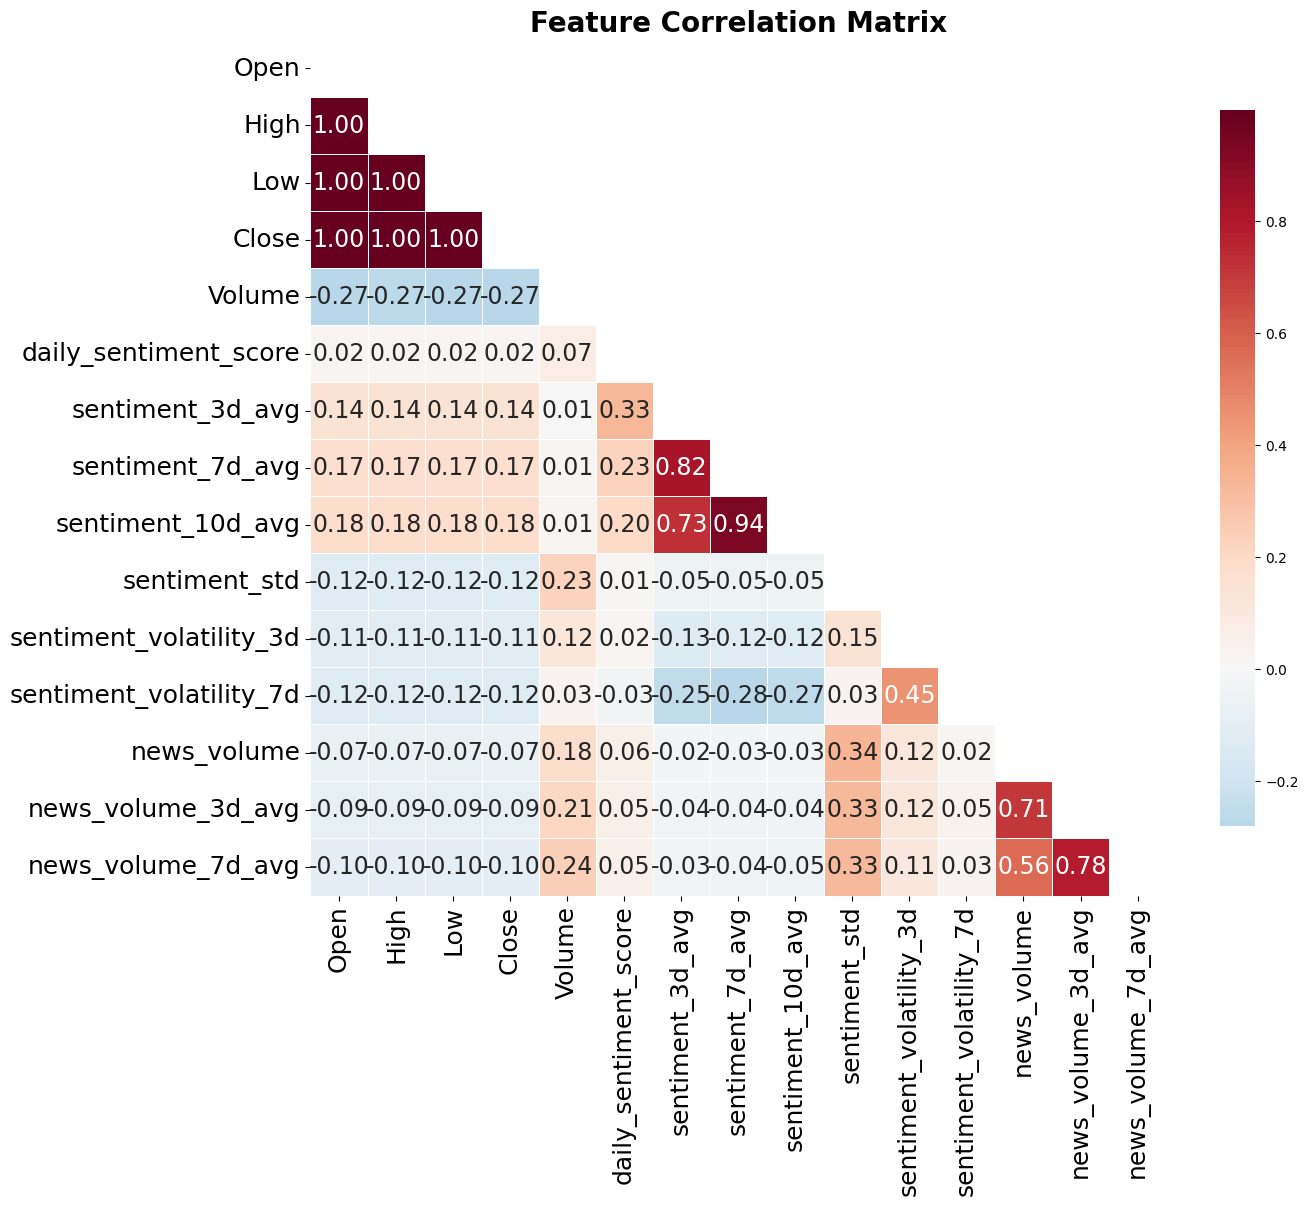


3. Creating volume chart for TOP 5 HIGH & LOWEST 5 volume stocks...


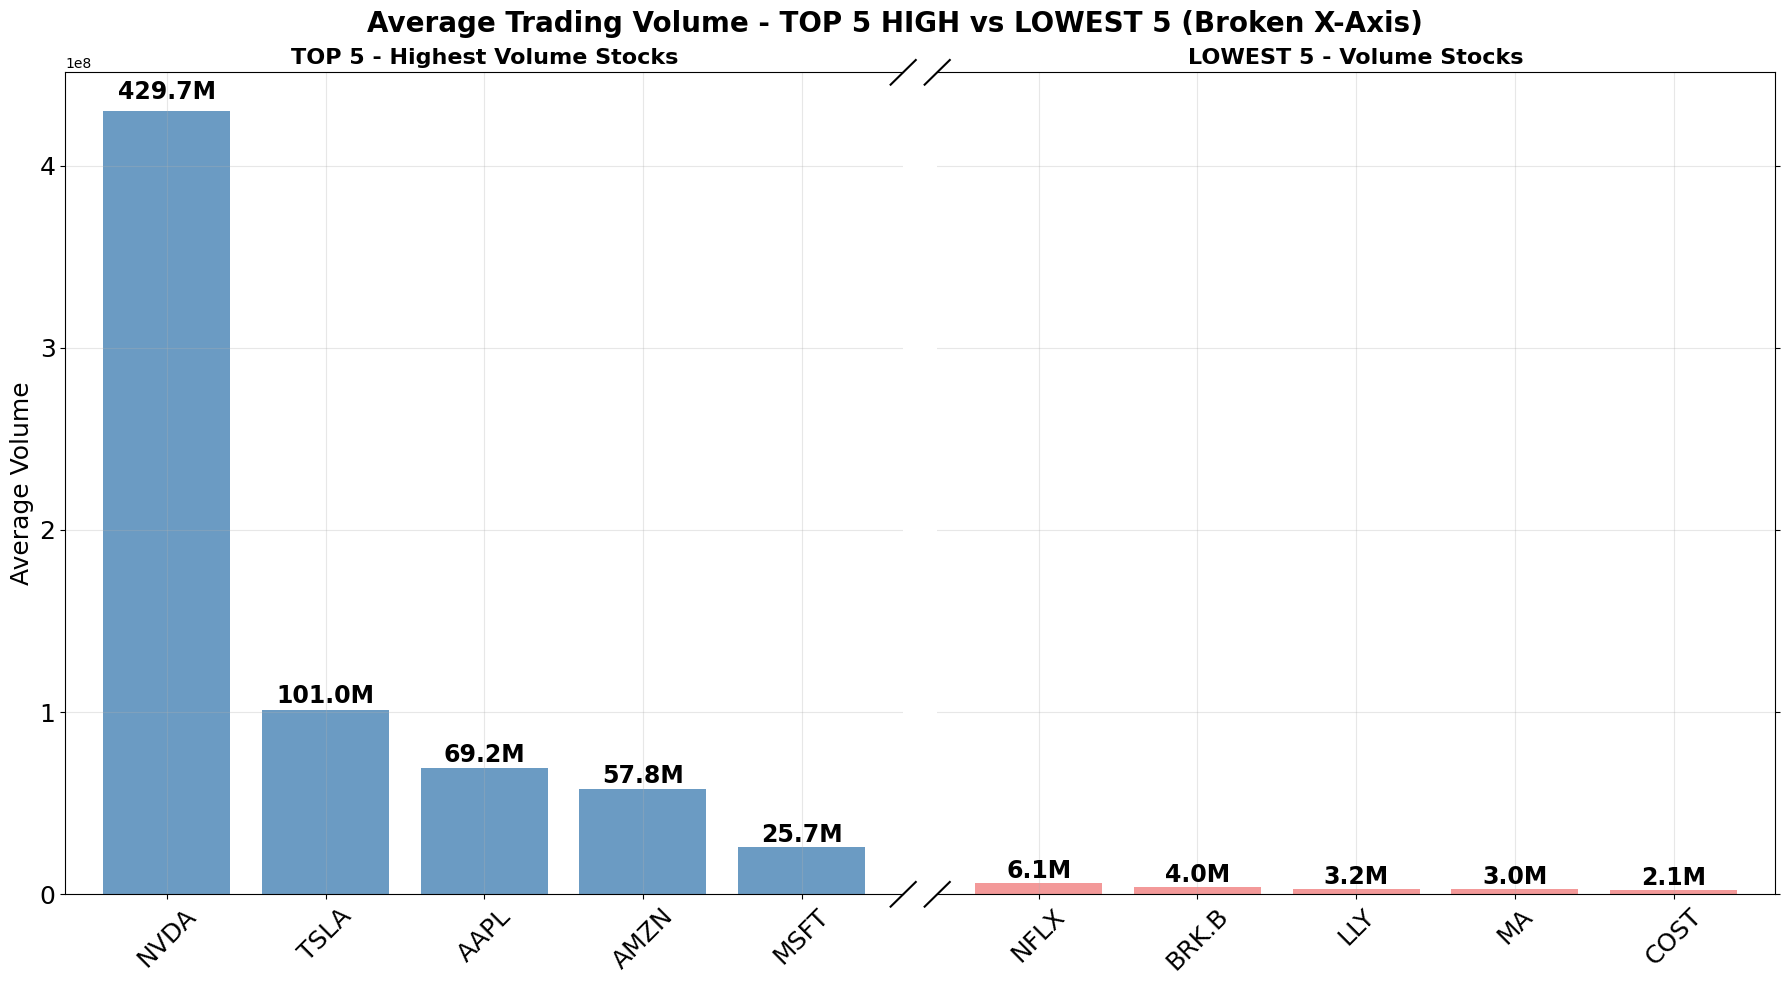

 TOP 5 HIGHEST Volume Stocks:
   1. NVDA: 429.7M avg volume
   2. TSLA: 101.0M avg volume
   3. AAPL: 69.2M avg volume
   4. AMZN: 57.8M avg volume
   5. MSFT: 25.7M avg volume

 LOWEST 5 Volume Stocks:
   1. NFLX: 6.1M avg volume
   2. BRK.B: 4.0M avg volume
   3. LLY: 3.2M avg volume
   4. MA: 3.0M avg volume
   5. COST: 2.1M avg volume

4. Creating sentiment chart for TOP 5 & LOWEST 5 sentiment stocks...


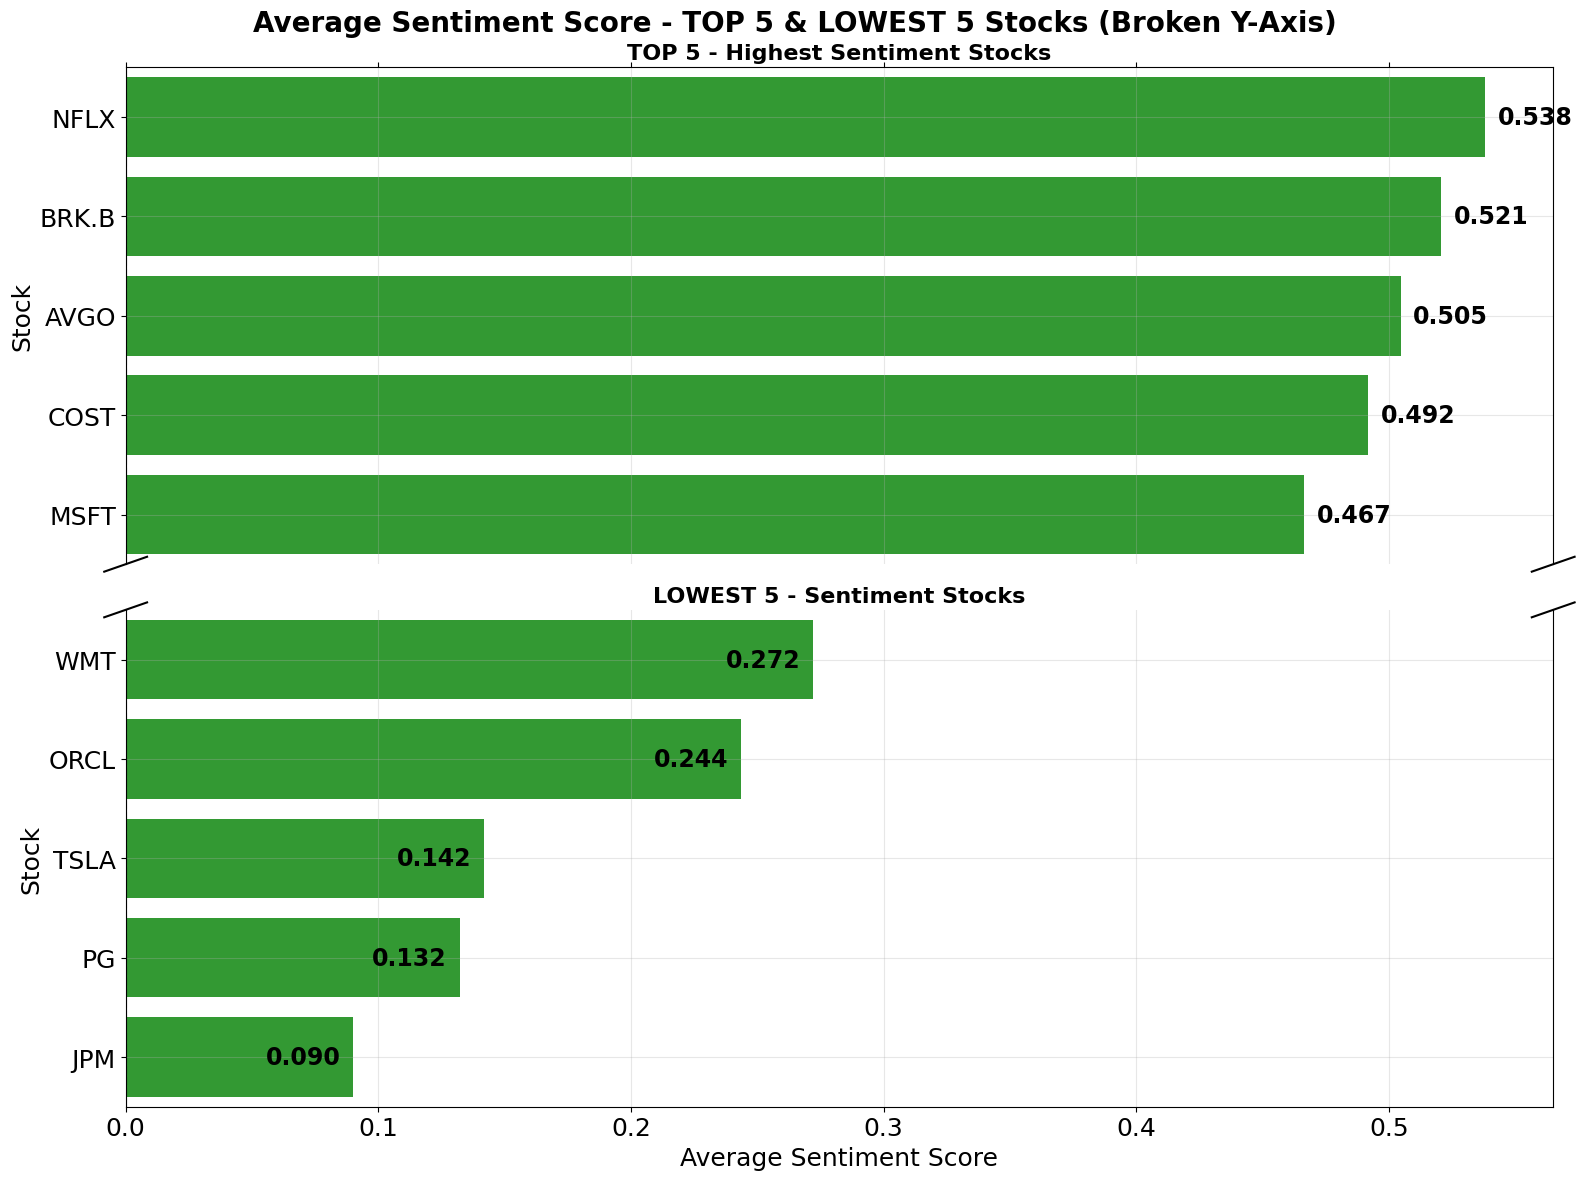

📊 TOP 5 HIGHEST Sentiment Stocks:
   1. MSFT: 0.467 avg sentiment
   2. COST: 0.492 avg sentiment
   3. AVGO: 0.505 avg sentiment
   4. BRK.B: 0.521 avg sentiment
   5. NFLX: 0.538 avg sentiment

📊 LOWEST 5 Sentiment Stocks:
   1. JPM: 0.090 avg sentiment
   2. PG: 0.132 avg sentiment
   3. TSLA: 0.142 avg sentiment
   4. ORCL: 0.244 avg sentiment
   5. WMT: 0.272 avg sentiment

5. Creating stock category analysis charts...

5A. Creating average volume by stock category...


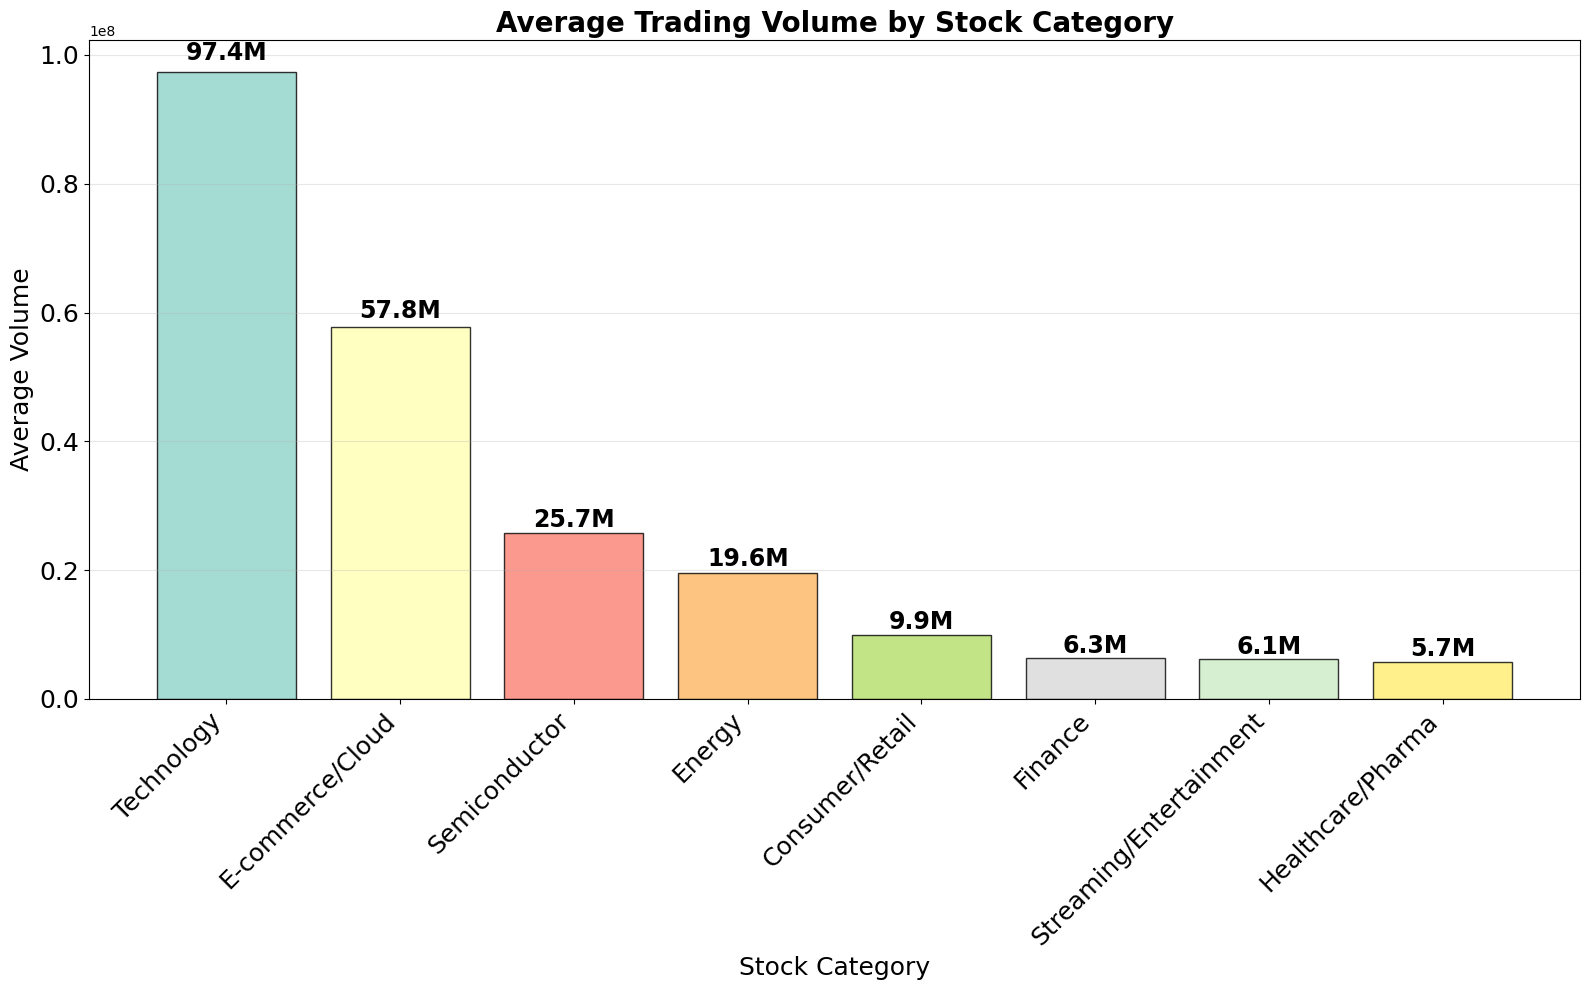

📊 Volume by Category Rankings:
   1. Technology: 97.4M avg volume (7 stocks: ['AAPL', 'MSFT', 'GOOG', 'META', 'NVDA', 'ORCL', 'TSLA'])
   2. E-commerce/Cloud: 57.8M avg volume (1 stocks: ['AMZN'])
   3. Semiconductor: 25.7M avg volume (1 stocks: ['AVGO'])
   4. Energy: 19.6M avg volume (1 stocks: ['XOM'])
   5. Consumer/Retail: 9.9M avg volume (3 stocks: ['WMT', 'COST', 'PG'])
   6. Finance: 6.3M avg volume (4 stocks: ['JPM', 'V', 'MA', 'BRK.B'])
   7. Streaming/Entertainment: 6.1M avg volume (1 stocks: ['NFLX'])
   8. Healthcare/Pharma: 5.7M avg volume (2 stocks: ['JNJ', 'LLY'])

5B. Creating average sentiment by stock category...


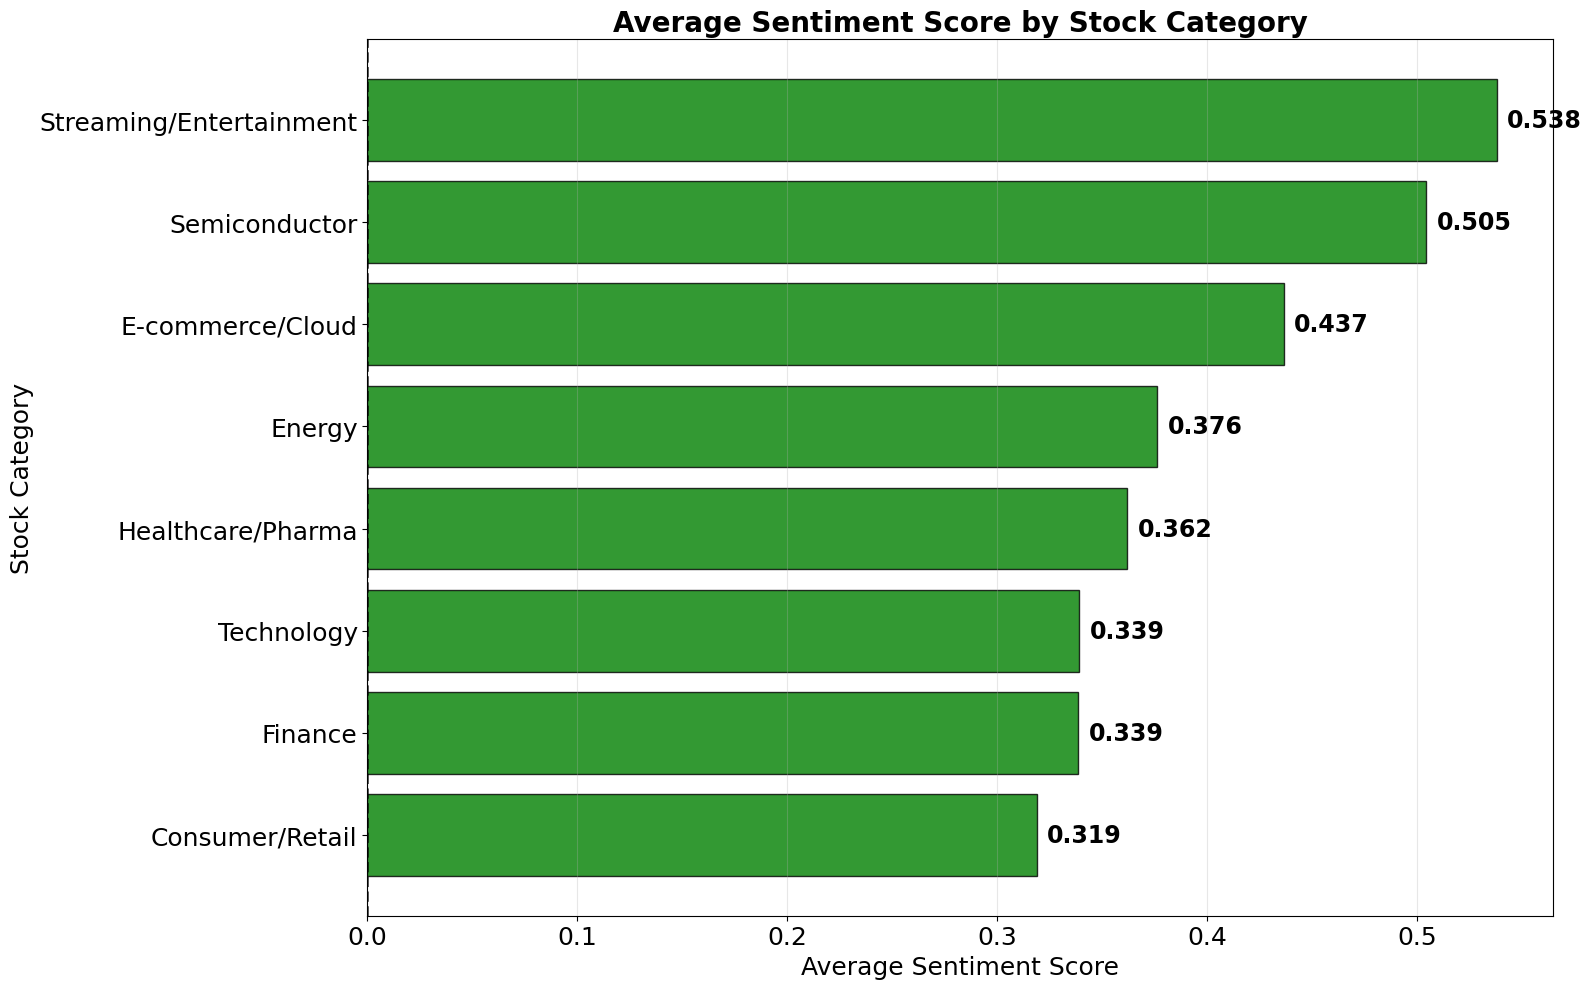

📊 Sentiment by Category Rankings:
   1. Consumer/Retail: 0.319 avg sentiment (3 stocks: ['WMT', 'COST', 'PG'])
   2. Finance: 0.339 avg sentiment (4 stocks: ['JPM', 'V', 'MA', 'BRK.B'])
   3. Technology: 0.339 avg sentiment (7 stocks: ['AAPL', 'MSFT', 'GOOG', 'META', 'NVDA', 'ORCL', 'TSLA'])
   4. Healthcare/Pharma: 0.362 avg sentiment (2 stocks: ['JNJ', 'LLY'])
   5. Energy: 0.376 avg sentiment (1 stocks: ['XOM'])
   6. E-commerce/Cloud: 0.437 avg sentiment (1 stocks: ['AMZN'])
   7. Semiconductor: 0.505 avg sentiment (1 stocks: ['AVGO'])
   8. Streaming/Entertainment: 0.538 avg sentiment (1 stocks: ['NFLX'])

5C. Creating stock category distribution pie chart...


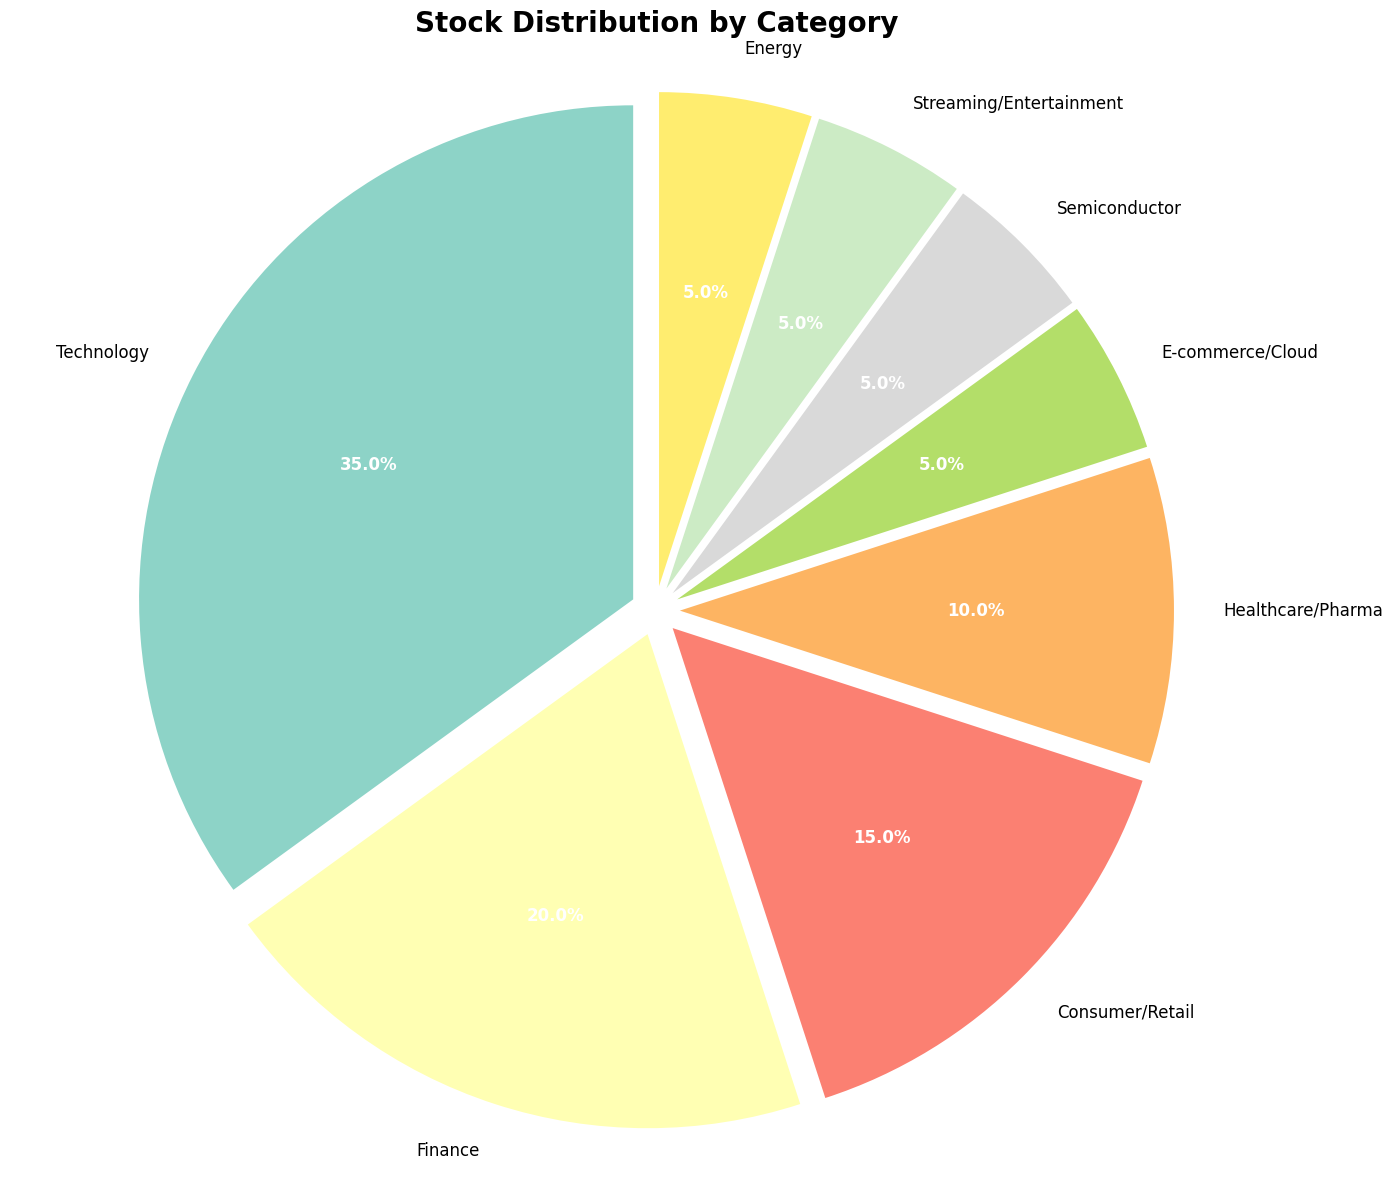

📊 Stock Distribution by Category:
   Technology: 7175 stocks (35875.0%) - ['AAPL', 'MSFT', 'GOOG', 'META', 'NVDA', 'ORCL', 'TSLA']
   Finance: 4100 stocks (20500.0%) - ['JPM', 'V', 'MA', 'BRK.B']
   Consumer/Retail: 3075 stocks (15375.0%) - ['WMT', 'COST', 'PG']
   Healthcare/Pharma: 2050 stocks (10250.0%) - ['JNJ', 'LLY']
   E-commerce/Cloud: 1025 stocks (5125.0%) - ['AMZN']
   Semiconductor: 1025 stocks (5125.0%) - ['AVGO']
   Streaming/Entertainment: 1025 stocks (5125.0%) - ['NFLX']
   Energy: 1025 stocks (5125.0%) - ['XOM']

6. Creating sentiment category distribution pie chart...


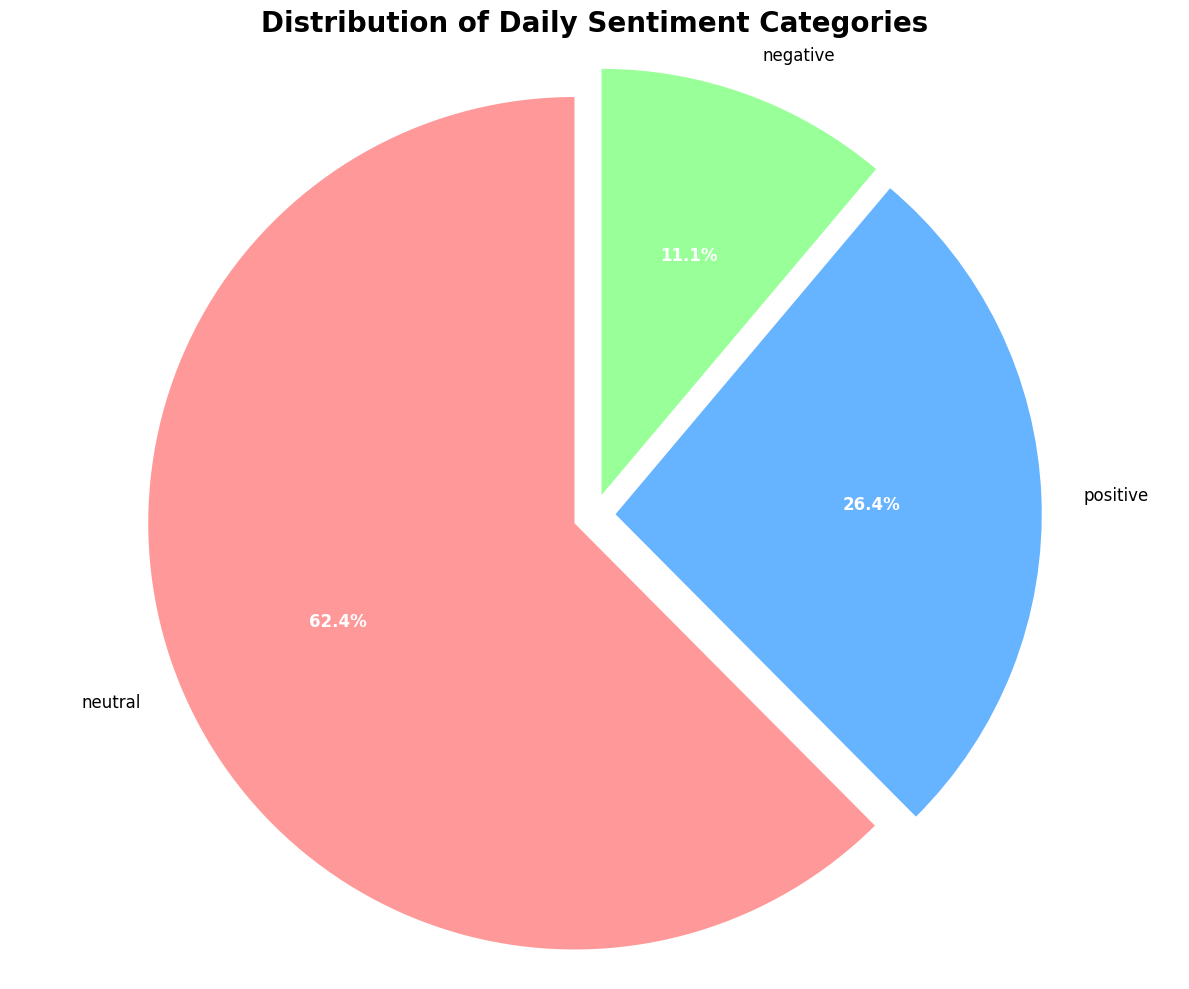


7A. Creating TOP 5 stocks ranked by positive sentiment distribution...


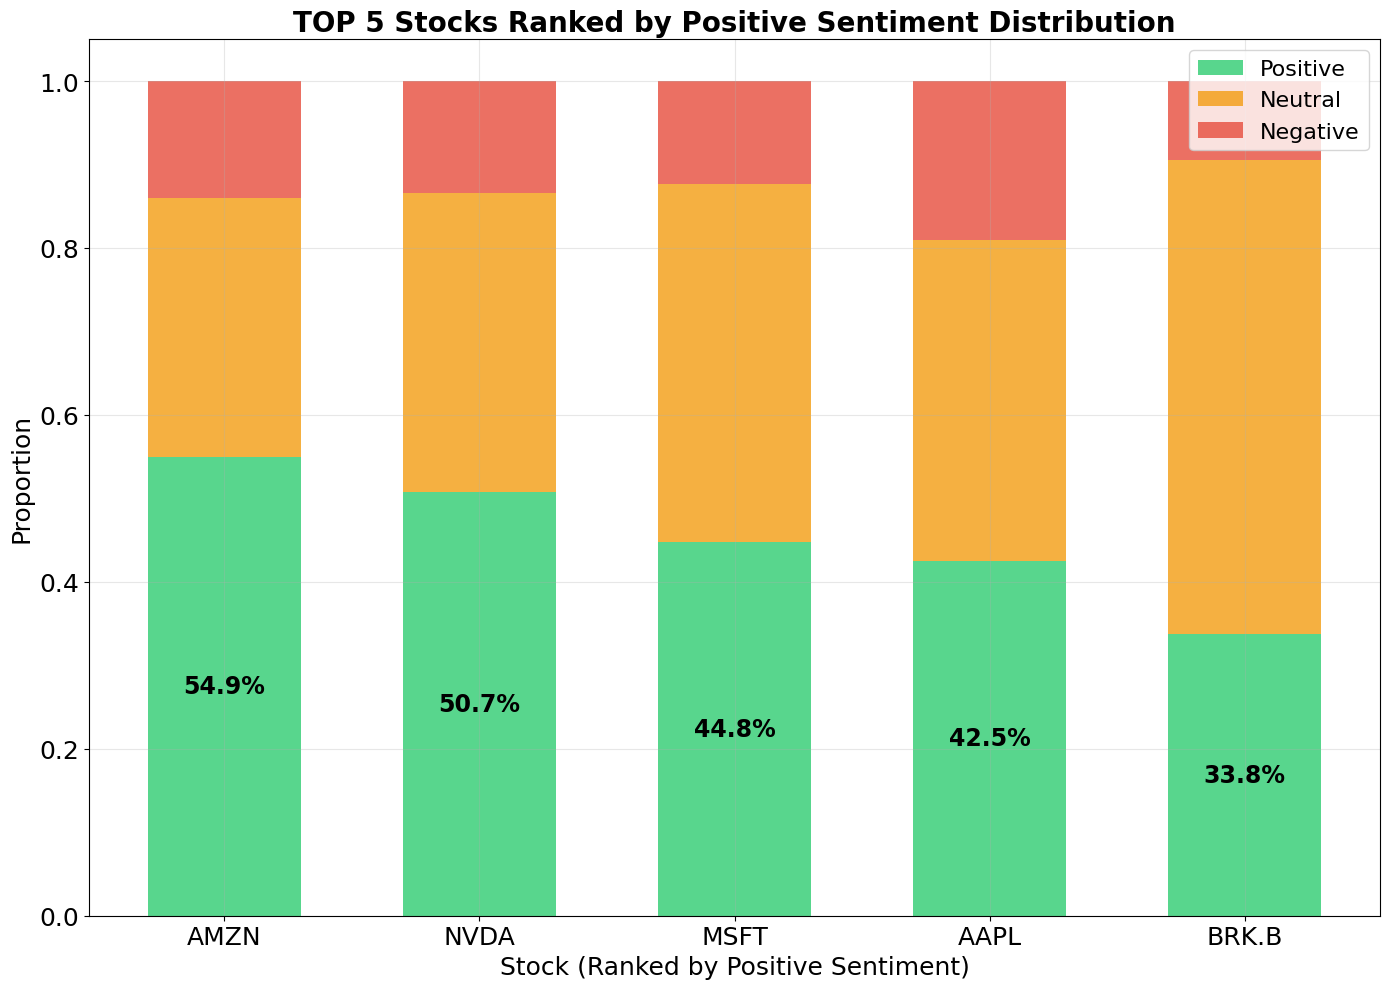


7B. Creating TOP 5 stocks ranked by negative sentiment distribution...


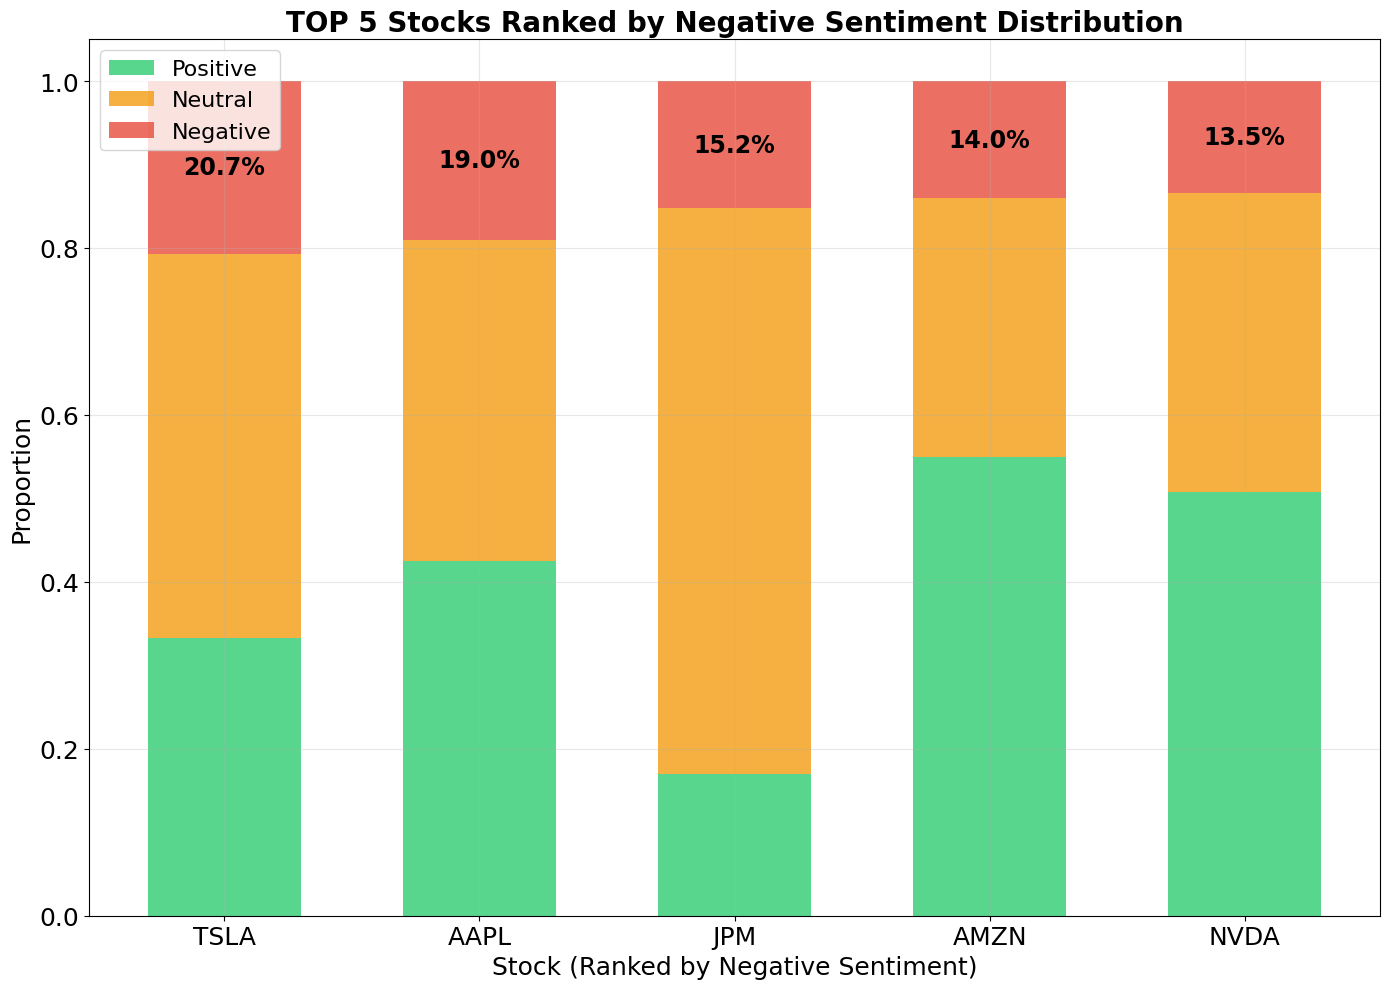


8. Creating sentiment distribution histogram grid by stock...


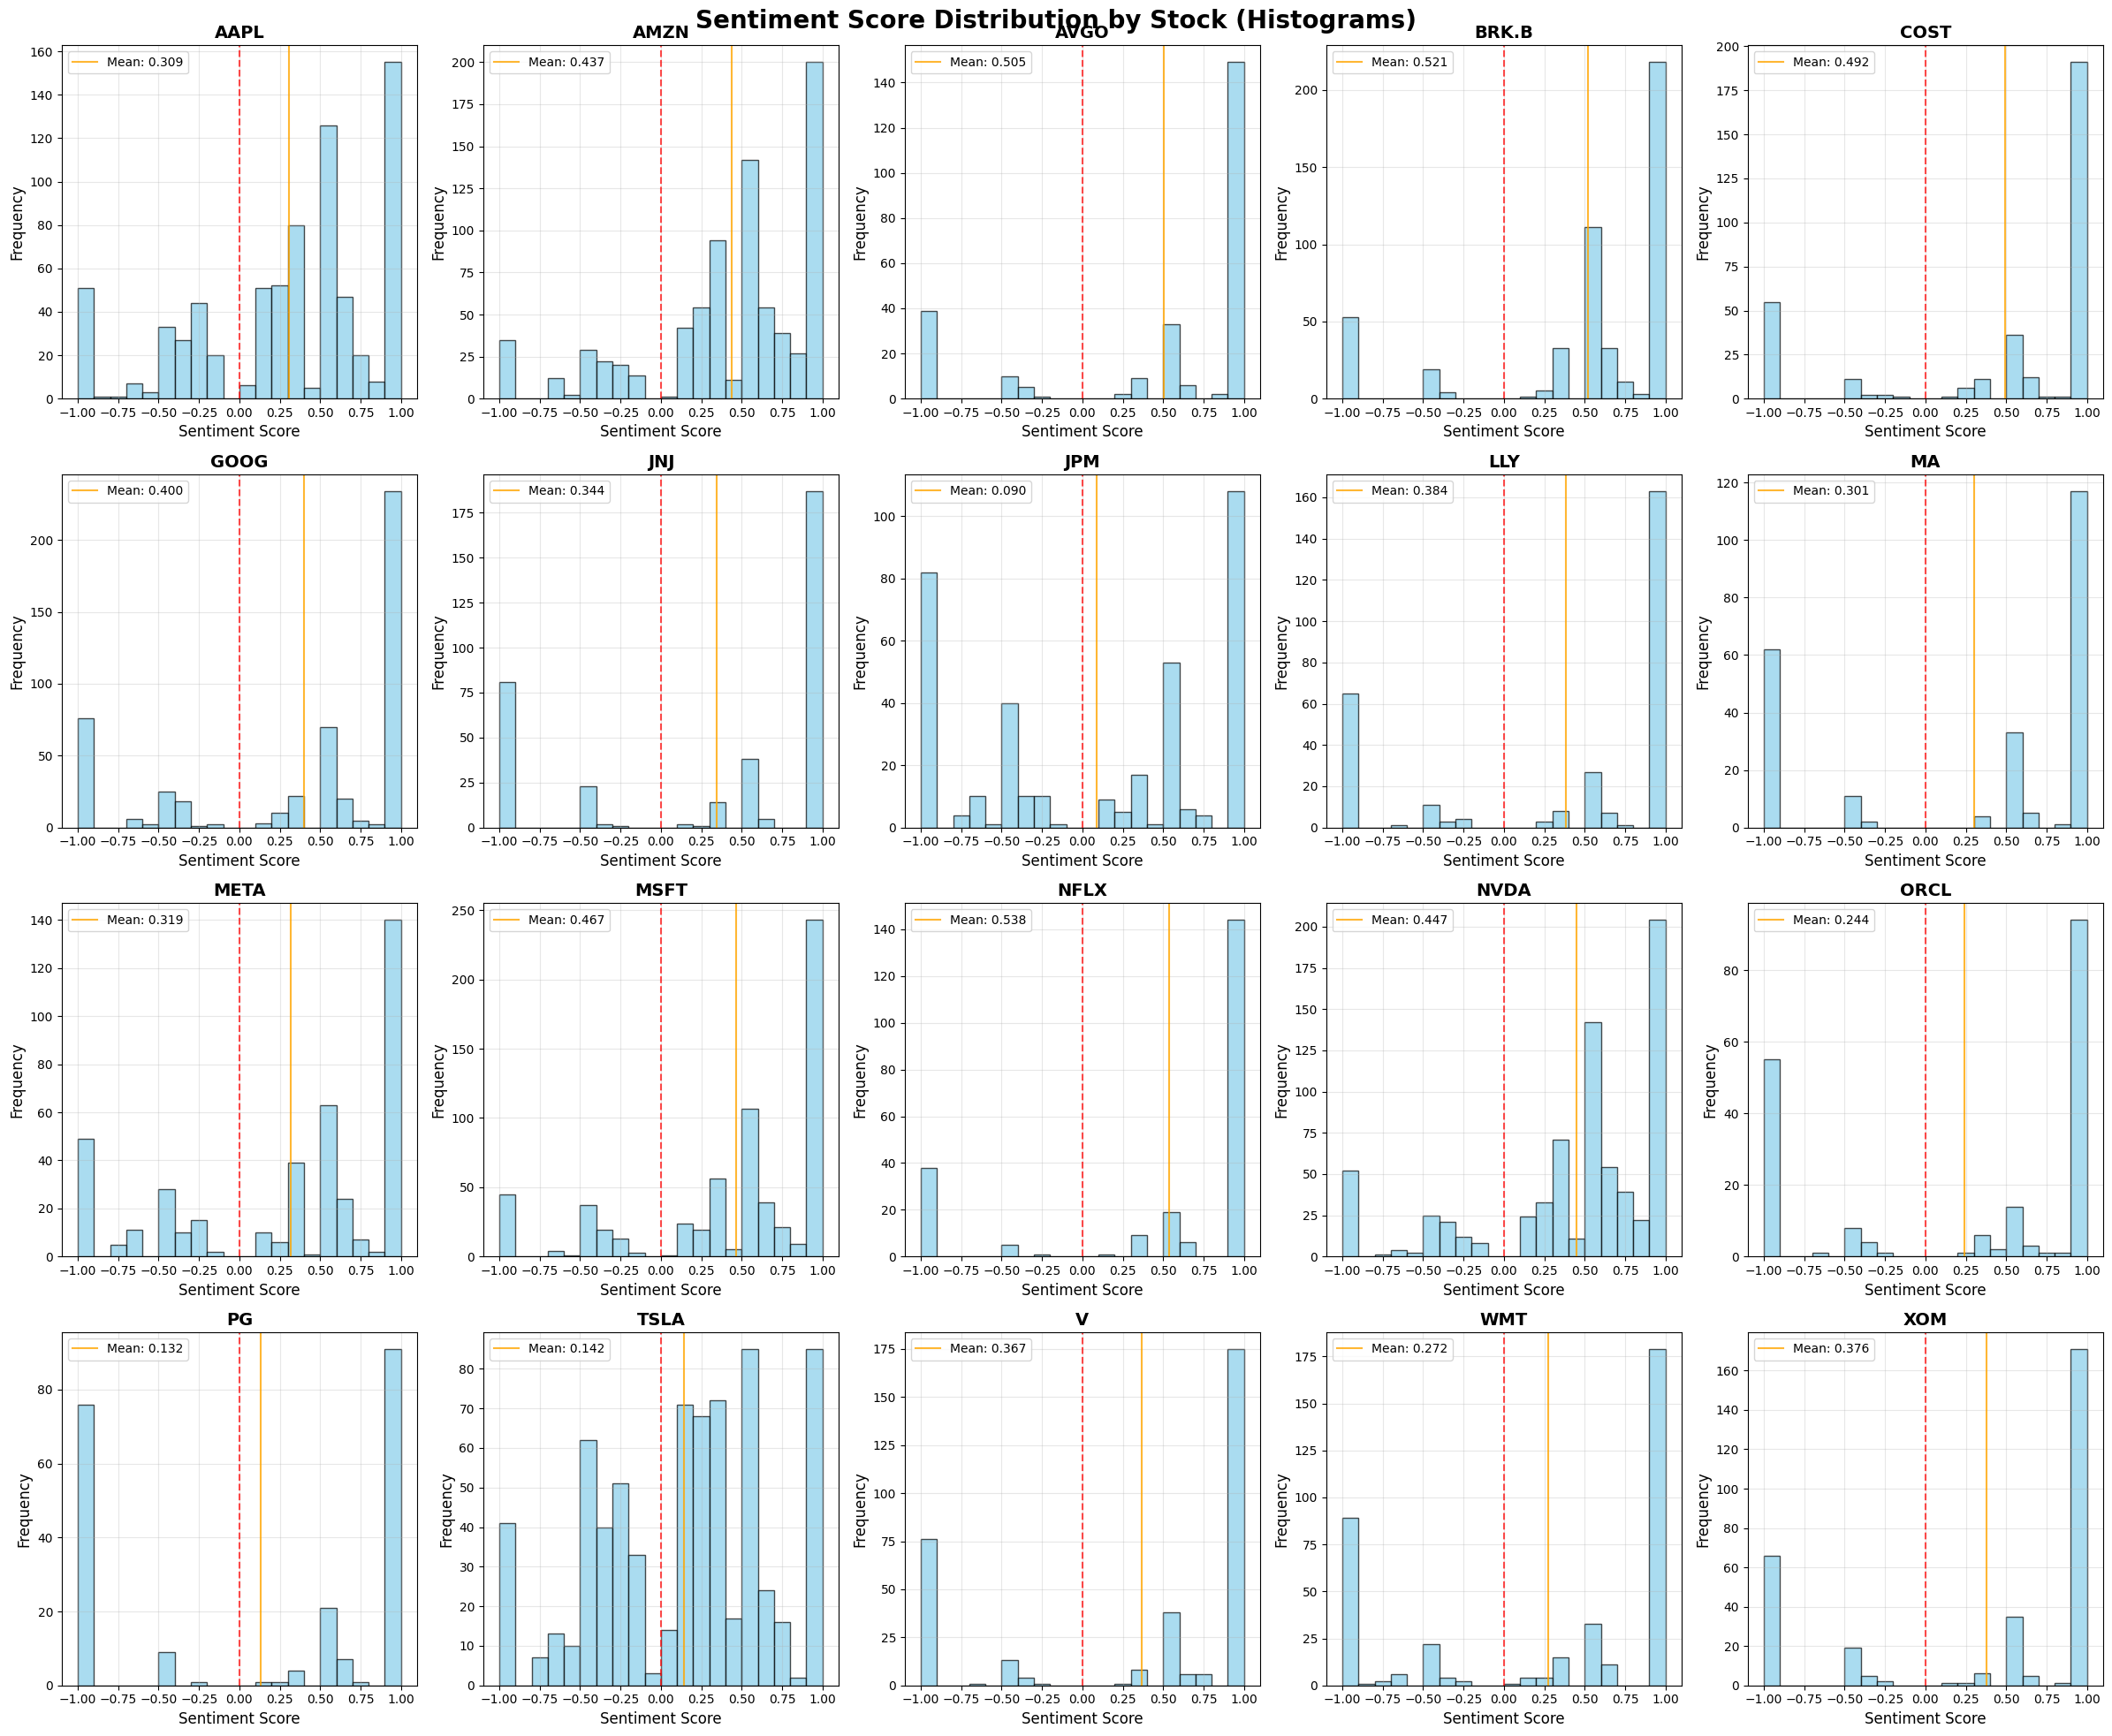


ALL VISUALIZATIONS SAVED AS PNG FILES:
1. mag7_stocks_price_5years.png
2. correlation_matrix.png
3. volume_by_stocks.png (TOP 5 HIGH vs LOWEST 5)
4. average_sentiment_by_stocks.png (TOP 5 vs LOWEST 5)
5A. volume_by_category.png (NEW - Volume by Stock Category)
5B. sentiment_by_category.png (NEW - Sentiment by Stock Category)
5C. stock_category_distribution.png (NEW - Category Distribution)
6. sentiment_category_distribution.png
7A. stocks_ranked_by_positive_sentiment.png (TOP 5 ONLY)
7B. stocks_ranked_by_negative_sentiment.png (TOP 5 ONLY)
8. sentiment_distribution_histogram_grid_by_stock.png

 Visualizations completed with all requested modifications:
    Volume chart: Shows TOP 5 highest & LOWEST 5 volume stocks
    Sentiment chart: Shows TOP 5 highest & LOWEST 5 sentiment stocks
    7A/7B charts: Show only TOP 5 stocks based on % values
    NEW Category Analysis: 3 new charts ranking by stock category instead of individual stocks
    Used sentiment column: daily_sentiment_score
   

In [25]:
# =====================================================
# SPECIFIC VISUALIZATIONS (Individual PNG files)
# =====================================================

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches

# FONT SIZE CONFIGURATION - Adjust these values as needed
TITLE_FONT_SIZE = 20
SUBTITLE_FONT_SIZE = 16
AXIS_LABEL_FONT_SIZE = 18
TICK_LABEL_FONT_SIZE = 18
LEGEND_FONT_SIZE = 16
BAR_LABEL_FONT_SIZE = 17
GRID_TITLE_FONT_SIZE = 14
GRID_AXIS_FONT_SIZE = 12
GRID_LEGEND_FONT_SIZE = 10
PIE_CHART_FONT_SIZE = 12

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

print("="*60)
print("CREATING SPECIFIC VISUALIZATIONS")
print("="*60)

# Get ML_COLUMNS for reference
try:
    ML_COLUMNS = globals()['ML_COLUMNS']
    print(f" Using ML_COLUMNS for visualization: {len(ML_COLUMNS)} columns")
except KeyError:
    ML_COLUMNS = list(final_df.columns)
    print(f" Using current dataframe columns for visualization")

# Define stock categories/sectors
stock_categories = {
    'Technology': ['AAPL', 'MSFT', 'GOOG', 'META', 'NVDA', 'ORCL', 'TSLA'],
    'E-commerce/Cloud': ['AMZN'],
    # 'Automotive/Energy': ['TSLA'],
    'Streaming/Entertainment': ['NFLX'],
    'Finance': ['JPM', 'V', 'MA', 'BRK.B'],
    'Healthcare/Pharma': ['JNJ', 'LLY'],
    'Consumer/Retail': ['WMT', 'COST', 'PG'],
    'Semiconductor': ['AVGO'],
    'Energy': ['XOM']
}

# Create reverse mapping for easy lookup
ticker_to_category = {}
for category, tickers in stock_categories.items():
    for ticker in tickers:
        ticker_to_category[ticker] = category

print(f" Stock Categories Defined:")
for category, tickers in stock_categories.items():
    print(f"   {category}: {tickers}")

# Define Magnificent 7 stocks
mag7_stocks = ['AAPL', 'MSFT', 'GOOGL', 'GOOG', 'AMZN', 'NVDA', 'TSLA', 'META']
available_mag7 = [stock for stock in mag7_stocks if stock in final_df['ticker'].unique()]
print(f"\nAvailable Mag 7 stocks: {available_mag7}")

# 1. Close Price for Mag 7 Stocks Over 5 Years
print("\n1. Creating Mag 7 stocks price chart...")
plt.figure(figsize=(16, 10))
for ticker in available_mag7:
    ticker_data = final_df[final_df['ticker'] == ticker].copy()
    ticker_data['Date'] = pd.to_datetime(ticker_data['Date'])
    ticker_data = ticker_data.sort_values('Date')
    
    # Filter last 5 years (from 2020 onwards)
    recent_data = ticker_data[ticker_data['Date'] >= '2020-01-01']
    plt.plot(recent_data['Date'], recent_data['Close'], 
             label=ticker, linewidth=2, alpha=0.8)

plt.title('Magnificent 7 Stocks - Close Price Over 5 Years', fontsize=TITLE_FONT_SIZE, fontweight='bold')
plt.xlabel('Date', fontsize=AXIS_LABEL_FONT_SIZE)
plt.ylabel('Close Price ($)', fontsize=AXIS_LABEL_FONT_SIZE)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=LEGEND_FONT_SIZE)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45, fontsize=TICK_LABEL_FONT_SIZE)
plt.yticks(fontsize=TICK_LABEL_FONT_SIZE)
plt.tight_layout()
plt.savefig('mag7_stocks_price_5years.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Correlation Matrix - using only available columns from ML_COLUMNS
print("\n2. Creating correlation matrix...")
plt.figure(figsize=(14, 12))

# Select numeric columns that exist in both ML_COLUMNS and final_df
available_numeric_cols = []
potential_numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'daily_sentiment_score', 
                         'sentiment_3d_avg', 'sentiment_7d_avg', 'sentiment_10d_avg',
                         'sentiment_std', 'sentiment_volatility_3d', 'sentiment_volatility_7d',
                         'news_volume', 'news_volume_3d_avg', 'news_volume_7d_avg']

for col in potential_numeric_cols:
    if col in final_df.columns and final_df[col].dtype in ['float64', 'int64']:
        available_numeric_cols.append(col)

print(f"Using numeric columns for correlation: {available_numeric_cols}")

if len(available_numeric_cols) >= 2:
    correlation_matrix = final_df[available_numeric_cols].corr()
    
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', center=0, 
                square=True, linewidths=0.5, fmt='.2f', mask=mask,
                cbar_kws={"shrink": .8}, annot_kws={'fontsize': BAR_LABEL_FONT_SIZE})
    plt.title('Feature Correlation Matrix', fontsize=TITLE_FONT_SIZE, fontweight='bold')
    plt.xticks(fontsize=TICK_LABEL_FONT_SIZE)
    plt.yticks(fontsize=TICK_LABEL_FONT_SIZE)
    plt.tight_layout()
    plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("❌ Not enough numeric columns for correlation matrix")

# 3. Volume by Stocks - TOP 5 HIGH & LOWEST 5 VOLUME STOCKS ONLY
print("\n3. Creating volume chart for TOP 5 HIGH & LOWEST 5 volume stocks...")
volume_by_stock = final_df.groupby('ticker')['Volume'].mean().sort_values(ascending=False)

# Get top 5 highest and lowest 5 volume stocks
top_5_volume = volume_by_stock.head(5)
bottom_5_volume = volume_by_stock.tail(5)

# Create figure with broken x-axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10), sharey=True)
fig.suptitle('Average Trading Volume - TOP 5 HIGH vs LOWEST 5 (Broken X-Axis)', fontsize=TITLE_FONT_SIZE, fontweight='bold')

# Plot top 5 highest volume stocks on left axis
x1 = range(len(top_5_volume))
bars1 = ax1.bar(x1, top_5_volume.values, color='steelblue', alpha=0.8)
ax1.set_xticks(x1)
ax1.set_xticklabels(top_5_volume.index, rotation=45, fontsize=TICK_LABEL_FONT_SIZE)
ax1.set_ylabel('Average Volume', fontsize=AXIS_LABEL_FONT_SIZE)
ax1.set_title('TOP 5 - Highest Volume Stocks', fontsize=SUBTITLE_FONT_SIZE, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='y', labelsize=TICK_LABEL_FONT_SIZE)

# Add value labels on bars
for i, bar in enumerate(bars1):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{height/1e6:.1f}M', ha='center', va='bottom', fontsize=BAR_LABEL_FONT_SIZE, fontweight='bold')

# Plot lowest 5 volume stocks on right axis
x2 = range(len(bottom_5_volume))
bars2 = ax2.bar(x2, bottom_5_volume.values, color='lightcoral', alpha=0.8)
ax2.set_xticks(x2)
ax2.set_xticklabels(bottom_5_volume.index, rotation=45, fontsize=TICK_LABEL_FONT_SIZE)
ax2.set_title('LOWEST 5 - Volume Stocks', fontsize=SUBTITLE_FONT_SIZE, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='y', labelsize=TICK_LABEL_FONT_SIZE)

# Add value labels on bars
for i, bar in enumerate(bars2):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{height/1e6:.1f}M', ha='center', va='bottom', fontsize=BAR_LABEL_FONT_SIZE, fontweight='bold')

# Add break indicators
ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax1.yaxis.tick_left()
ax2.yaxis.tick_right()

# Add diagonal lines to indicate break
d = 0.015  # how big to make the diagonal lines
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((1-d, 1+d), (-d, +d), **kwargs)
ax1.plot((1-d, 1+d), (1-d, 1+d), **kwargs)

kwargs.update(transform=ax2.transAxes)
ax2.plot((-d, +d), (1-d, 1+d), **kwargs)
ax2.plot((-d, +d), (-d, +d), **kwargs)

plt.tight_layout()
plt.savefig('volume_by_stocks.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary
print(f" TOP 5 HIGHEST Volume Stocks:")
for i, (stock, volume) in enumerate(top_5_volume.items(), 1):
    print(f"   {i}. {stock}: {volume/1e6:.1f}M avg volume")

print(f"\n LOWEST 5 Volume Stocks:")
for i, (stock, volume) in enumerate(bottom_5_volume.items(), 1):
    print(f"   {i}. {stock}: {volume/1e6:.1f}M avg volume")

# 4. Average Sentiment by Stocks - TOP 5 & LOWEST 5 SENTIMENT STOCKS ONLY
print("\n4. Creating sentiment chart for TOP 5 & LOWEST 5 sentiment stocks...")

# Use the correct sentiment column name
sentiment_col = 'daily_sentiment_score' if 'daily_sentiment_score' in final_df.columns else 'avg_sentiment_score'

if sentiment_col in final_df.columns:
    # Only consider non-zero sentiment scores for true averages
    sentiment_by_stock = final_df[final_df[sentiment_col] != 0].groupby('ticker')[sentiment_col].mean().sort_values()
    
    # Get top 5 highest and lowest 5 sentiment stocks
    bottom_5_sentiment = sentiment_by_stock.head(5)  # Lowest sentiment (most negative)
    top_5_sentiment = sentiment_by_stock.tail(5)     # Highest sentiment (most positive)
    
    # Create figure with broken y-axis
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12), sharex=True)
    fig.suptitle('Average Sentiment Score - TOP 5 & LOWEST 5 Stocks (Broken Y-Axis)', fontsize=TITLE_FONT_SIZE, fontweight='bold')
    
    # Determine break points
    min_val = bottom_5_sentiment.min()
    max_val = top_5_sentiment.max()
    
    # Define break points - separate negative from positive sentiment
    negative_threshold = -0.05
    positive_threshold = 0.05
    
    # Combine stocks for display
    combined_stocks = pd.concat([bottom_5_sentiment, top_5_sentiment])
    colors = ['red' if x < 0 else 'green' if x > 0 else 'gray' for x in combined_stocks.values]
    
    # Upper subplot (positive values) - TOP 5 HIGHEST SENTIMENT
    top_5_indices = range(len(combined_stocks) - len(top_5_sentiment), len(combined_stocks))
    top_5_colors = [colors[i] for i in top_5_indices]
    
    bars1 = ax1.barh(range(len(top_5_sentiment)), top_5_sentiment.values, 
                     color=top_5_colors, alpha=0.8)
    ax1.set_ylim(-0.5, len(top_5_sentiment) - 0.5)
    ax1.axvline(x=0, color='black', linestyle='--', alpha=0.5)
    ax1.set_ylabel('Stock', fontsize=AXIS_LABEL_FONT_SIZE)
    ax1.set_title('TOP 5 - Highest Sentiment Stocks', fontsize=SUBTITLE_FONT_SIZE, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.set_yticks(range(len(top_5_sentiment)))
    ax1.set_yticklabels(top_5_sentiment.index, fontsize=TICK_LABEL_FONT_SIZE)
    ax1.tick_params(axis='x', labelsize=TICK_LABEL_FONT_SIZE)
    
    # Lower subplot (negative values) - LOWEST 5 SENTIMENT
    bottom_5_colors = colors[:len(bottom_5_sentiment)]
    
    bars2 = ax2.barh(range(len(bottom_5_sentiment)), bottom_5_sentiment.values, 
                     color=bottom_5_colors, alpha=0.8)
    ax2.set_ylim(-0.5, len(bottom_5_sentiment) - 0.5)
    ax2.axvline(x=0, color='black', linestyle='--', alpha=0.5)
    ax2.set_xlabel('Average Sentiment Score', fontsize=AXIS_LABEL_FONT_SIZE)
    ax2.set_ylabel('Stock', fontsize=AXIS_LABEL_FONT_SIZE)
    ax2.set_title('LOWEST 5 - Sentiment Stocks', fontsize=SUBTITLE_FONT_SIZE, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.set_yticks(range(len(bottom_5_sentiment)))
    ax2.set_yticklabels(bottom_5_sentiment.index, fontsize=TICK_LABEL_FONT_SIZE)
    ax2.tick_params(axis='x', labelsize=TICK_LABEL_FONT_SIZE)
    
    # Add value labels
    for i, (stock, value) in enumerate(top_5_sentiment.items()):
        ax1.text(value + 0.005, i, f'{value:.3f}', 
                ha='left', va='center', fontsize=BAR_LABEL_FONT_SIZE, fontweight='bold')
    
    for i, (stock, value) in enumerate(bottom_5_sentiment.items()):
        ax2.text(value - 0.005, i, f'{value:.3f}', 
                ha='right', va='center', fontsize=BAR_LABEL_FONT_SIZE, fontweight='bold')
    
    # Hide spines between subplots
    ax1.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax1.xaxis.tick_top()
    ax1.tick_params(labeltop=False)
    ax2.xaxis.tick_bottom()
    
    # Add diagonal lines to indicate break
    d = 0.015
    kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
    ax1.plot((-d, +d), (-d, +d), **kwargs)
    ax1.plot((1-d, 1+d), (-d, +d), **kwargs)
    
    kwargs.update(transform=ax2.transAxes)
    ax2.plot((-d, +d), (1-d, 1+d), **kwargs)
    ax2.plot((1-d, 1+d), (1-d, 1+d), **kwargs)
    
    plt.tight_layout()
    plt.savefig('average_sentiment_by_stocks.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print summary
    print(f"📊 TOP 5 HIGHEST Sentiment Stocks:")
    for i, (stock, sentiment) in enumerate(top_5_sentiment.items(), 1):
        print(f"   {i}. {stock}: {sentiment:.3f} avg sentiment")

    print(f"\n📊 LOWEST 5 Sentiment Stocks:")
    for i, (stock, sentiment) in enumerate(bottom_5_sentiment.items(), 1):
        print(f"   {i}. {stock}: {sentiment:.3f} avg sentiment")
        
else:
    print(f"❌ Sentiment column not found for visualization")

# 5. STOCK CATEGORY ANALYSIS - NEW ADDITION
print("\n5. Creating stock category analysis charts...")

# Add category column to dataframe for analysis
final_df_with_category = final_df.copy()
final_df_with_category['category'] = final_df_with_category['ticker'].map(ticker_to_category)

# 5A. Average Volume by Stock Category
print("\n5A. Creating average volume by stock category...")
volume_by_category = final_df_with_category.groupby('category')['Volume'].mean().sort_values(ascending=False)

plt.figure(figsize=(16, 10))
colors_volume = plt.cm.Set3(np.linspace(0, 1, len(volume_by_category)))
bars = plt.bar(range(len(volume_by_category)), volume_by_category.values, 
               color=colors_volume, alpha=0.8, edgecolor='black', linewidth=1)

plt.title('Average Trading Volume by Stock Category', fontsize=TITLE_FONT_SIZE, fontweight='bold')
plt.xlabel('Stock Category', fontsize=AXIS_LABEL_FONT_SIZE)
plt.ylabel('Average Volume', fontsize=AXIS_LABEL_FONT_SIZE)
plt.xticks(range(len(volume_by_category)), volume_by_category.index, rotation=45, ha='right', fontsize=TICK_LABEL_FONT_SIZE)
plt.yticks(fontsize=TICK_LABEL_FONT_SIZE)
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{height/1e6:.1f}M', ha='center', va='bottom', fontsize=BAR_LABEL_FONT_SIZE, fontweight='bold')

plt.tight_layout()
plt.savefig('volume_by_category.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary
print(f"📊 Volume by Category Rankings:")
for i, (category, volume) in enumerate(volume_by_category.items(), 1):
    stocks_in_category = [k for k, v in ticker_to_category.items() if v == category and k in final_df['ticker'].unique()]
    print(f"   {i}. {category}: {volume/1e6:.1f}M avg volume ({len(stocks_in_category)} stocks: {stocks_in_category})")

# 5B. Average Sentiment by Stock Category
if sentiment_col in final_df_with_category.columns:
    print("\n5B. Creating average sentiment by stock category...")
    
    # Only consider non-zero sentiment scores for true averages
    sentiment_by_category = final_df_with_category[final_df_with_category[sentiment_col] != 0].groupby('category')[sentiment_col].mean().sort_values()
    
    plt.figure(figsize=(16, 10))
    colors_sentiment = ['red' if x < 0 else 'green' if x > 0 else 'gray' for x in sentiment_by_category.values]
    bars = plt.barh(range(len(sentiment_by_category)), sentiment_by_category.values, 
                    color=colors_sentiment, alpha=0.8, edgecolor='black', linewidth=1)
    
    plt.title('Average Sentiment Score by Stock Category', fontsize=TITLE_FONT_SIZE, fontweight='bold')
    plt.xlabel('Average Sentiment Score', fontsize=AXIS_LABEL_FONT_SIZE)
    plt.ylabel('Stock Category', fontsize=AXIS_LABEL_FONT_SIZE)
    plt.yticks(range(len(sentiment_by_category)), sentiment_by_category.index, fontsize=TICK_LABEL_FONT_SIZE)
    plt.xticks(fontsize=TICK_LABEL_FONT_SIZE)
    plt.axvline(x=0, color='black', linestyle='--', alpha=0.7, linewidth=2)
    plt.grid(True, alpha=0.3, axis='x')
    
    # Add value labels
    for i, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(width + (0.005 if width >= 0 else -0.005), bar.get_y() + bar.get_height()/2.,
                 f'{width:.3f}', ha='left' if width >= 0 else 'right', va='center', 
                 fontsize=BAR_LABEL_FONT_SIZE, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('sentiment_by_category.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print summary
    print(f"📊 Sentiment by Category Rankings:")
    for i, (category, sentiment) in enumerate(sentiment_by_category.items(), 1):
        stocks_in_category = [k for k, v in ticker_to_category.items() if v == category and k in final_df['ticker'].unique()]
        print(f"   {i}. {category}: {sentiment:.3f} avg sentiment ({len(stocks_in_category)} stocks: {stocks_in_category})")

# 5C. Stock Category Distribution (Pie Chart)
print("\n5C. Creating stock category distribution pie chart...")
category_counts = final_df_with_category['category'].value_counts()

plt.figure(figsize=(14, 12))
colors_pie = plt.cm.Set3(np.linspace(0, 1, len(category_counts)))
wedges, texts, autotexts = plt.pie(category_counts.values, labels=category_counts.index, 
                                  autopct='%1.1f%%', startangle=90, colors=colors_pie, 
                                  explode=[0.05] * len(category_counts), 
                                  textprops={'fontsize': PIE_CHART_FONT_SIZE})

# Enhance text appearance
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(PIE_CHART_FONT_SIZE)

plt.title('Stock Distribution by Category', fontsize=TITLE_FONT_SIZE, fontweight='bold')
plt.axis('equal')
plt.tight_layout()
plt.savefig('stock_category_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary
print(f"📊 Stock Distribution by Category:")
total_stocks = len(final_df['ticker'].unique())
for category, count in category_counts.items():
    percentage = (count / total_stocks) * 100
    stocks_in_category = [k for k, v in ticker_to_category.items() if v == category and k in final_df['ticker'].unique()]
    print(f"   {category}: {count} stocks ({percentage:.1f}%) - {stocks_in_category}")

# 6. Sentiment Category Distribution (Pie Chart)
print("\n6. Creating sentiment category distribution pie chart...")
if 'daily_sentiment_category' in final_df.columns:
    plt.figure(figsize=(12, 10))
    sentiment_counts = final_df['daily_sentiment_category'].value_counts()
    colors = ['#ff9999', '#66b3ff', '#99ff99']  # Red, Blue, Green
    wedges, texts, autotexts = plt.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%', 
            startangle=90, colors=colors, explode=(0.05, 0.05, 0.05),
            textprops={'fontsize': PIE_CHART_FONT_SIZE})
    
    # Enhance text appearance
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(PIE_CHART_FONT_SIZE)
    
    plt.title('Distribution of Daily Sentiment Categories', fontsize=TITLE_FONT_SIZE, fontweight='bold')
    plt.axis('equal')
    plt.tight_layout()
    plt.savefig('sentiment_category_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("❌ daily_sentiment_category column not found")

# 7A & 7B. TOP 5 Stocks Ranked by Sentiment Distribution
if 'daily_sentiment_category' in final_df.columns:
    print("\n7A. Creating TOP 5 stocks ranked by positive sentiment distribution...")
    
    # Calculate sentiment distribution for each stock
    stocks = sorted(final_df['ticker'].unique())
    sentiment_data = {}
    for stock in stocks:
        stock_data = final_df[final_df['ticker'] == stock]
        sentiment_dist = stock_data['daily_sentiment_category'].value_counts(normalize=True)
        sentiment_data[stock] = {
            'positive': sentiment_dist.get('positive', 0),
            'neutral': sentiment_dist.get('neutral', 0),
            'negative': sentiment_dist.get('negative', 0)
        }

    # Sort by positive sentiment (descending) and take TOP 5
    sorted_by_positive = sorted(sentiment_data.items(), key=lambda x: x[1]['positive'], reverse=True)[:5]
    sorted_stocks = [item[0] for item in sorted_by_positive]
    sorted_sentiment_array = np.array([[item[1]['positive'], item[1]['neutral'], item[1]['negative']] for item in sorted_by_positive])

    plt.figure(figsize=(14, 10))
    x = np.arange(len(sorted_stocks))
    width = 0.6

    # Create stacked bar chart
    p1 = plt.bar(x, sorted_sentiment_array[:, 0], width, label='Positive', color='#2ecc71', alpha=0.8)
    p2 = plt.bar(x, sorted_sentiment_array[:, 1], width, bottom=sorted_sentiment_array[:, 0], 
                 label='Neutral', color='#f39c12', alpha=0.8)
    p3 = plt.bar(x, sorted_sentiment_array[:, 2], width, 
                 bottom=sorted_sentiment_array[:, 0] + sorted_sentiment_array[:, 1],
                 label='Negative', color='#e74c3c', alpha=0.8)

    # Add percentage labels for positive sentiment
    for i, (stock, data) in enumerate(sorted_by_positive):
        plt.text(i, data['positive']/2, f"{data['positive']:.1%}", 
                 ha='center', va='center', fontweight='bold', fontsize=BAR_LABEL_FONT_SIZE)

    plt.title('TOP 5 Stocks Ranked by Positive Sentiment Distribution', fontsize=TITLE_FONT_SIZE, fontweight='bold')
    plt.xlabel('Stock (Ranked by Positive Sentiment)', fontsize=AXIS_LABEL_FONT_SIZE)
    plt.ylabel('Proportion', fontsize=AXIS_LABEL_FONT_SIZE)
    plt.xticks(x, sorted_stocks, fontsize=TICK_LABEL_FONT_SIZE)
    plt.yticks(fontsize=TICK_LABEL_FONT_SIZE)
    plt.legend(fontsize=LEGEND_FONT_SIZE)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('stocks_ranked_by_positive_sentiment.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\n7B. Creating TOP 5 stocks ranked by negative sentiment distribution...")
    
    # Sort by negative sentiment (descending) and take TOP 5
    sorted_by_negative = sorted(sentiment_data.items(), key=lambda x: x[1]['negative'], reverse=True)[:5]
    sorted_stocks_neg = [item[0] for item in sorted_by_negative]
    sorted_sentiment_array_neg = np.array([[item[1]['positive'], item[1]['neutral'], item[1]['negative']] for item in sorted_by_negative])

    plt.figure(figsize=(14, 10))
    x = np.arange(len(sorted_stocks_neg))
    width = 0.6

    # Create stacked bar chart
    p1 = plt.bar(x, sorted_sentiment_array_neg[:, 0], width, label='Positive', color='#2ecc71', alpha=0.8)
    p2 = plt.bar(x, sorted_sentiment_array_neg[:, 1], width, bottom=sorted_sentiment_array_neg[:, 0], 
                 label='Neutral', color='#f39c12', alpha=0.8)
    p3 = plt.bar(x, sorted_sentiment_array_neg[:, 2], width, 
                 bottom=sorted_sentiment_array_neg[:, 0] + sorted_sentiment_array_neg[:, 1],
                 label='Negative', color='#e74c3c', alpha=0.8)

    # Add percentage labels for negative sentiment
    for i, (stock, data) in enumerate(sorted_by_negative):
        plt.text(i, data['positive'] + data['neutral'] + data['negative']/2, f"{data['negative']:.1%}", 
                 ha='center', va='center', fontweight='bold', fontsize=BAR_LABEL_FONT_SIZE)

    plt.title('TOP 5 Stocks Ranked by Negative Sentiment Distribution', fontsize=TITLE_FONT_SIZE, fontweight='bold')
    plt.xlabel('Stock (Ranked by Negative Sentiment)', fontsize=AXIS_LABEL_FONT_SIZE)
    plt.ylabel('Proportion', fontsize=AXIS_LABEL_FONT_SIZE)
    plt.xticks(x, sorted_stocks_neg, fontsize=TICK_LABEL_FONT_SIZE)
    plt.yticks(fontsize=TICK_LABEL_FONT_SIZE)
    plt.legend(fontsize=LEGEND_FONT_SIZE)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('stocks_ranked_by_negative_sentiment.png', dpi=300, bbox_inches='tight')
    plt.show()

# 8. SENTIMENT DISTRIBUTION BY STOCK - HISTOGRAM GRID
if sentiment_col in final_df.columns:
    print("\n8. Creating sentiment distribution histogram grid by stock...")
    fig, axes = plt.subplots(4, 5, figsize=(24, 20))
    fig.suptitle('Sentiment Score Distribution by Stock (Histograms)', fontsize=TITLE_FONT_SIZE, fontweight='bold')

    # Filter data with actual sentiment scores (non-zero)
    sentiment_data_hist = final_df[final_df[sentiment_col] != 0].copy()
    stocks = sorted(sentiment_data_hist['ticker'].unique())

    for i, stock in enumerate(stocks):
        row = i // 5
        col = i % 5
        
        stock_sentiment = sentiment_data_hist[sentiment_data_hist['ticker'] == stock][sentiment_col]
        
        axes[row, col].hist(stock_sentiment, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
        axes[row, col].axvline(x=0, color='red', linestyle='--', alpha=0.7)
        axes[row, col].axvline(x=stock_sentiment.mean(), color='orange', linestyle='-', alpha=0.8, 
                              label=f'Mean: {stock_sentiment.mean():.3f}')
        axes[row, col].set_title(f'{stock}', fontsize=GRID_TITLE_FONT_SIZE, fontweight='bold')
        axes[row, col].set_xlabel('Sentiment Score', fontsize=GRID_AXIS_FONT_SIZE)
        axes[row, col].set_ylabel('Frequency', fontsize=GRID_AXIS_FONT_SIZE)
        axes[row, col].tick_params(axis='both', labelsize=GRID_AXIS_FONT_SIZE-2)
        axes[row, col].grid(True, alpha=0.3)
        axes[row, col].legend(fontsize=GRID_LEGEND_FONT_SIZE)

    # Hide empty subplots if any
    for i in range(len(stocks), 20):
        row = i // 5
        col = i % 5
        axes[row, col].set_visible(False)

    plt.tight_layout()
    plt.savefig('sentiment_distribution_histogram_grid_by_stock.png', dpi=300, bbox_inches='tight')
    plt.show()

print("\n" + "="*60)
print("ALL VISUALIZATIONS SAVED AS PNG FILES:")
print("1. mag7_stocks_price_5years.png")
print("2. correlation_matrix.png") 
print("3. volume_by_stocks.png (TOP 5 HIGH vs LOWEST 5)")
print("4. average_sentiment_by_stocks.png (TOP 5 vs LOWEST 5)")
print("5A. volume_by_category.png (NEW - Volume by Stock Category)")
print("5B. sentiment_by_category.png (NEW - Sentiment by Stock Category)")
print("5C. stock_category_distribution.png (NEW - Category Distribution)")
print("6. sentiment_category_distribution.png")
print("7A. stocks_ranked_by_positive_sentiment.png (TOP 5 ONLY)")
print("7B. stocks_ranked_by_negative_sentiment.png (TOP 5 ONLY)")
print("8. sentiment_distribution_histogram_grid_by_stock.png")
print("="*60)

print(f"\n Visualizations completed with all requested modifications:")
print(f"    Volume chart: Shows TOP 5 highest & LOWEST 5 volume stocks")
print(f"    Sentiment chart: Shows TOP 5 highest & LOWEST 5 sentiment stocks")
print(f"    7A/7B charts: Show only TOP 5 stocks based on % values")
print(f"    NEW Category Analysis: 3 new charts ranking by stock category instead of individual stocks")
print(f"    Used sentiment column: {sentiment_col if sentiment_col in final_df.columns else 'None available'}")
print(f"    All charts now provide both individual and category-level insights")

In [22]:
## Summary of Added Technical Indicators

print("="*80)
print("TECHNICAL INDICATORS ADDED TO DATASET")
print("="*80)

# Define technical indicators that were added
technical_indicators = {
    'MA_3': 'Simple Moving Average (3 days)',
    'MA_7': 'Simple Moving Average (7 days)', 
    'MA_10': 'Simple Moving Average (10 days)',
    'RSI': 'Relative Strength Index (14-period)',
    'MACD': 'MACD Line (12-26 EMA)',
    'MACD_Signal': 'MACD Signal Line (9-period EMA)',
    'MACD_Histogram': 'MACD Histogram (MACD - Signal)'
}

print(" Successfully added 7 technical indicators:")
for indicator, description in technical_indicators.items():
    print(f"    {indicator}: {description}")

# Check if final dataset has technical indicators
if 'final_df' in locals() and len(final_df) > 0:
    print(f"\n Final dataset shape: {final_df.shape}")
    
    # Show sample with technical indicators
    tech_cols = ['ticker', 'Date', 'Close'] + list(technical_indicators.keys())
    available_tech_cols = [col for col in tech_cols if col in final_df.columns]
    
    if len(available_tech_cols) > 3:  # At least ticker, Date, Close + some technical indicators
        print(f"\n Sample data with technical indicators:")
        sample_data = final_df[available_tech_cols].head(10)
        print(sample_data.to_string(index=False))
        
        # Show some statistics
        print(f"\n Technical Indicator Statistics (for {final_df['ticker'].iloc[0]}):")
        first_ticker_data = final_df[final_df['ticker'] == final_df['ticker'].iloc[0]]
        for col in technical_indicators.keys():
            if col in final_df.columns:
                values = first_ticker_data[col]
                print(f"   {col}: Mean={values.mean():.2f}, Std={values.std():.2f}, Range=[{values.min():.2f}, {values.max():.2f}]")
    else:
        print(f"\n  Technical indicators not found in final dataset")
        print(f"Available columns: {list(final_df.columns)}")
else:
    print(f"\n  Final dataset not available for display")

print(f"\n BENEFITS OF ADDED TECHNICAL INDICATORS:")
print(f"   • Moving Averages: Identify trend direction and momentum")
print(f"   • RSI: Detect overbought/oversold conditions (0-100 scale)")
print(f"   • MACD: Track momentum changes and trend reversals")
print(f"   • These indicators enhance ML model prediction capabilities")

print(f"\n Dataset is now ready with both sentiment and technical features!")
print("="*80)


TECHNICAL INDICATORS ADDED TO DATASET
 Successfully added 7 technical indicators:
    MA_3: Simple Moving Average (3 days)
    MA_7: Simple Moving Average (7 days)
    MA_10: Simple Moving Average (10 days)
    RSI: Relative Strength Index (14-period)
    MACD: MACD Line (12-26 EMA)
    MACD_Signal: MACD Signal Line (9-period EMA)
    MACD_Histogram: MACD Histogram (MACD - Signal)

 Final dataset shape: (20500, 26)

 Sample data with technical indicators:
ticker       Date      Close       MA_3       MA_7      MA_10  RSI      MACD
  AAPL 2021-05-21 122.748177 122.748177 122.748177 122.748177 50.0  0.000000
  AAPL 2021-05-24 124.382477 123.565327 123.565327 123.565327 50.0  0.036667
  AAPL 2021-05-25 124.186737 123.772463 123.772463 123.772463 50.0  0.040651
  AAPL 2021-05-26 124.137810 124.235675 123.863800 123.863800 50.0  0.039700
  AAPL 2021-05-27 122.601395 123.641980 123.611319 123.611319 50.0 -0.022789
  AAPL 2021-05-28 121.945709 122.894971 123.333717 123.333717 50.0 -0.087963
 